#LSTM AND BI-LSTM for Temperature Prediction

In [2]:
# pip install 

In [134]:
# import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset
# from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
os.getcwd()

'/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Temperature'

**Data Importation and Information**

In [3]:
# data for Abidjan
Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})

# print(df.info())
# df.describe(),data_.describe()
# df.head(4) 

/tmp/ipykernel_1914949/3409575691.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/tmp/ipykernel_1914949/3409575691.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [4]:
##### No missing for both datasets ###
# Abj_dt.isna().sum()
# Kgl_dt.isnull().sum()
Abj_dt.columns


Index(['datetime', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS'],
      dtype='object')

In [5]:
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt=Kgl_dt.rename(columns=col_name_map)



In [69]:
print(Abj_dt.info())
print(Kgl_dt.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5114 entries, 2010-01-01 to 2024-01-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ASWD    5114 non-null   float64
 1   CSWD    5114 non-null   float64
 2   ALWD    5114 non-null   float64
 3   T2M     5114 non-null   float64
 4   T2MDEW  5114 non-null   float64
 5   T2MWET  5114 non-null   float64
 6   QV2M    5114 non-null   float64
 7   RH2M    5114 non-null   float64
 8   PREC    5114 non-null   float64
 9   PS      5114 non-null   float64
dtypes: float64(10)
memory usage: 439.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5114 entries, 2010-01-01 to 2024-01-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ASWD    5114 non-null   float64
 1   CSWD    5114 non-null   float64
 2   ALWD    5114 non-null   float64
 3   T2M     5114 non-null   float64
 4   T2MDEW  5114 non-null   float64

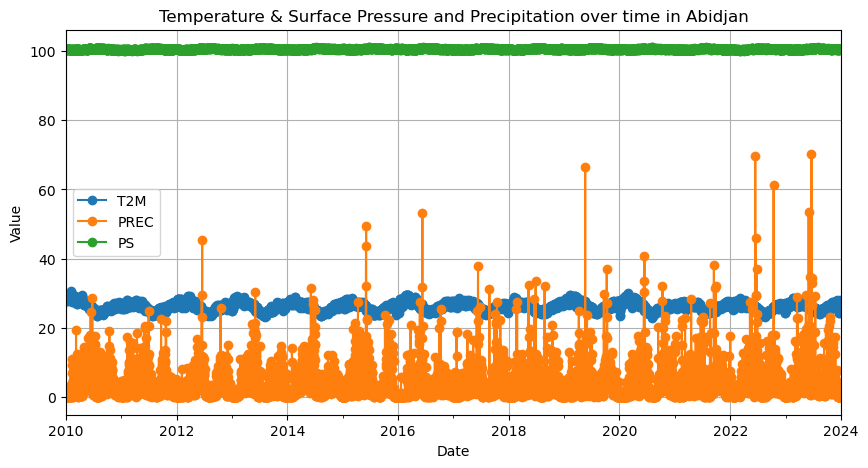

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

# Select specific variables to plot
columns_to_plot = ['T2M', 'PREC','PS']

# Plot
Abj_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Abidjan')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()


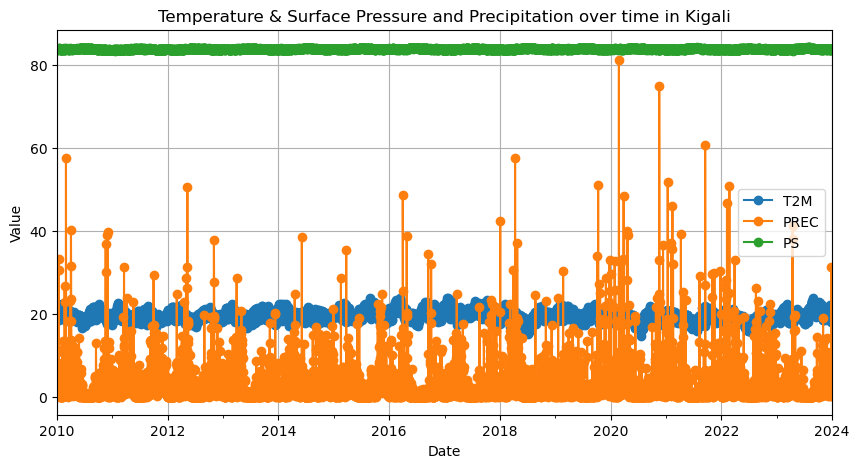

In [246]:
# Plot
Kgl_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Kigali')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()

In [ ]:
# Plot
df.plot(x='Date', y=columns_to_plot, figsize=(10, 5), marker='o')
plt.title('Temperature & Humidity Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid()
plt.show()

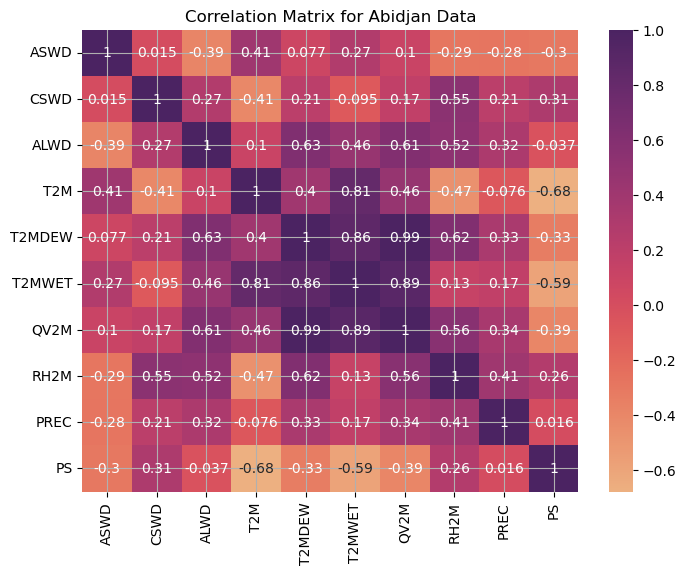

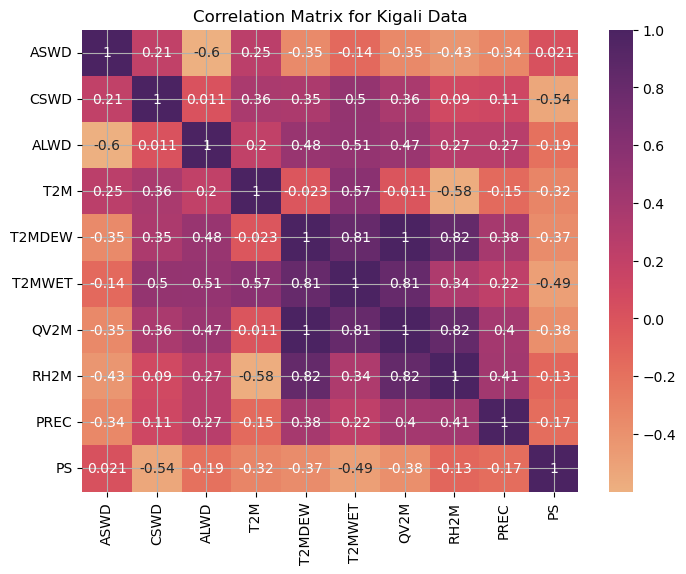

In [7]:
# df.columns,df_.columns
def displayHeatMap(dim1, dim2, title, df):
    fig=plt.figure(figsize=(dim1,dim2))
    plt.title(title)
    sns.heatmap(df, annot= True, cmap='flare')
# Define correlation matrix for both data
corr_Abj= Abj_dt.iloc[:,1:].corr()
corr_Kgl= Kgl_dt.iloc[:,1:].corr()
# Display the heatmap
displayHeatMap(8, 6,"Correlation Matrix for Abidjan Data",corr_Abj)
displayHeatMap(8, 6,"Correlation Matrix for Kigali Data",corr_Kgl)

In [8]:
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")

In [180]:
# Abj_dt.columns

Index(['ASWD', 'CSWD', 'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PREC', 'PS'],
      dtype='object')

**Variable ploting**

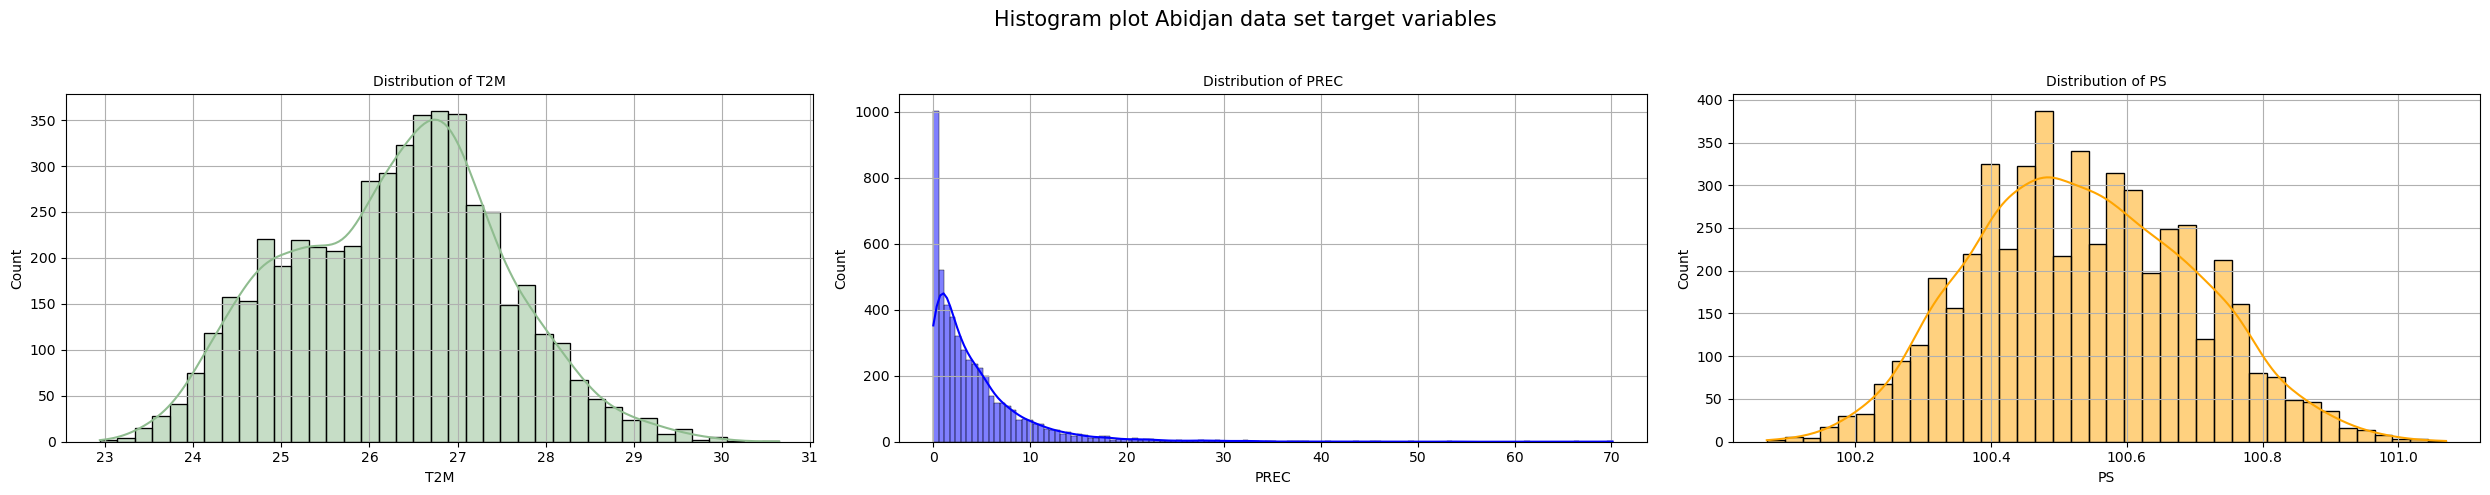

In [10]:
# df['Days'] = pd.to_datetime(df['Days'], dayfirst=True)
# df.index = pd.to_datetime(df['Days'],infer_datetime_format=True )
# plt.figure(figsize=(9,9))
# df.set_index('Days')[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
#        'CSSWDW', 'T2MDEW', 'ALLSKYDW']].plot(subplots=True)
#plotting histograms of each category to idenitfy patterns in the data
import matplotlib.pyplot as plt
import seaborn as sns

def showDistributions(df, categories, per_column=True, color=["darkseagreen", "blue", "orange"], title="Original Data"):
    if per_column:
        fig, axes = plt.subplots(1, len(categories), figsize=(25, 5))

        # Ensure color list length matches categories
        if isinstance(color, str):  
            color = [color] * len(categories)  # Convert single color to list
        elif len(color) != len(categories):
            raise ValueError("The length of the color list must match the number of categories.")

        for i in range(len(categories)):
            sns.histplot(data=df, x=categories[i], kde=True, color=color[i], ax=axes[i])
            axes[i].set_title(f"Distribution of {categories[i]}",fontsize=10)

        plt.suptitle(title, fontsize=15, color="black")  # Use a single color
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title

    else:
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.histplot(data=df, x=categories[0], kde=True, color=color[0], ax=ax)  # Use first category for plotting
        ax.set_title(f"Distribution of {categories[0]}")

    plt.show()


showDistributions(Abj_dt,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

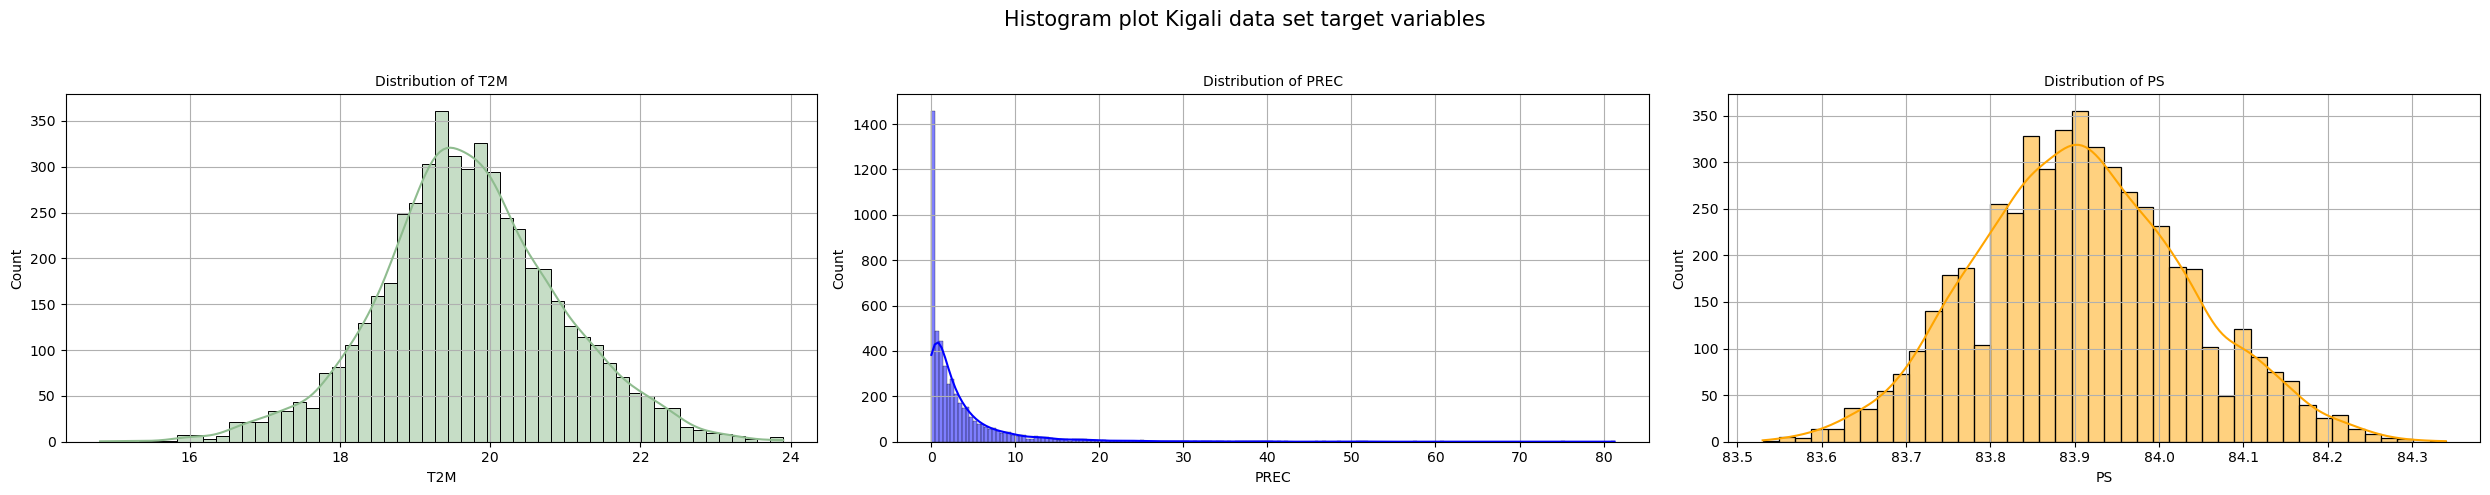

In [11]:
#Handle missing values
showDistributions(Kgl_dt,["T2M","PREC","PS"],title="Histogram plot Kigali data set target variables")
# df = df.fillna(method='ffill')a  # Forward fill for simplicity, or use df.dropna() to remove rows with NaNs
# print(df.isnull().sum())  # Verify no missing values remain


In [12]:
# scaler = MinMaxScaler(feature_range=(0,1))
# kgl=Kgl_dt[['PREC','PS']][:10]
# kgl[['PREC','PS']]=scaler.fit_transform(kgl)

In [13]:
kgl
# dt

PREC        PS
datetime                      
2010-01-01  0.081349  0.428571
2010-01-02  0.053571  1.000000
2010-01-03  0.000000  0.857143
2010-01-04  0.053571  0.500000
2010-01-05  0.223214  0.357143
2010-01-06  0.581349  0.000000
2010-01-07  0.050595  0.071429
2010-01-08  0.133929  0.428571
2010-01-09  0.018849  0.928571
2010-01-10  1.000000  0.714286

In [14]:
#################### Datapreprocessing For Temperature   #####################

# Sorting the dates
# Kgl_dt_input= Kgl_dt.sort_index()
# Abj_dt_input= Abj_dt.sort_index()
# Scalling
# scaler = MinMaxScaler()
def Make_tidydata(data,scaler):
    data= data.sort_index()
    data[data.columns] = scaler.fit_transform(data[data.columns])
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return Xy_train,Xy_val,Xy_test

# Define the TimeSeriesDataset class
# class TimeSeriesDataset(Dataset):
#     def __init__(self, features, target, window_length):
#         self.features = features
#         self.target = target
#         self.window_length = window_length
#     def __len__(self):
#         return len(self.features) - self.window_length
#     def __getitem__(self, idx):
#         X = self.features[idx:idx + self.window_length]
#         y = self.target[idx + self.window_length]
#         return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
## Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, n_steps_in, n_steps_out,target_names):
        """
        Initialize the dataset with a pandas DataFrame.
        Parameters:
        - dataframe: Pandas DataFrame containing the time series data.
        - n_steps_in: Number of time steps for input.
        - n_steps_out: Number of time steps for output.
        -target_names: NAmes of the target variables.
        """
        self.dataframe = dataframe
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out   
        self.target_names=target_names   
        # Prepare the input and output sequences
        self.X, self.y = self.sliding_window(self.dataframe, self.n_steps_in, self.n_steps_out,self.target_names)
    def sliding_window(self, dataframe, n_steps_in, n_steps_out,target_names):
        X, y = list(), list()  
        for i in range(len(dataframe)):
            end_idx = i + n_steps_in
            out_end_idx = end_idx + n_steps_out - 1
            # Ensure valid index range
            if out_end_idx >= len(dataframe):
                break
            # Extract X and y sequences
            seq_x = dataframe.iloc[i:end_idx, :].values  # X sequence
            seq_y = dataframe[target_names][end_idx:out_end_idx + 1].values  # y sequence (last column)| Redefine this!!!
            # Check if `seq_y` is shorter than `n_steps_out`
            if len(seq_y) < n_steps_out:
                pad_length = n_steps_out - len(seq_y)
                avg_value = np.mean(seq_y)  # Calculate the average of `seq_y`
                # Pad `seq_y` with the average value
                seq_y = np.pad(seq_y, (0, pad_length), 'constant', constant_values=avg_value)
            # Ensure `seq_y` is a 2D array
            if len(seq_y.shape) == 1:
                seq_y = seq_y.reshape(-1, 1)
            # Append the sequences to the list
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Return the input-output pair for the given index
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
# Create data loaders
def create_data_loaders(TimeSeriesDataset,Make_tidydata,df,target_names,scaler,window_length,obs_length,batch_size):
    Xy_train,Xy_val,Xy_test=Make_tidydata(df,scaler)
    # Creating time series data
    train_dataset = TimeSeriesDataset(Xy_train,obs_length, window_length,target_names)
    val_dataset = TimeSeriesDataset(Xy_val, obs_length, window_length,target_names)
    test_dataset = TimeSeriesDataset(Xy_test, obs_length, window_length,target_names)
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader

# Create DataLoaders for Abidjan and Kigali  
batch_size = 64
window_length = 1
obs_length=14
scaler=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(0,1))]
target_names=['T2M','PREC','PS']
Abj_train_loader,Abj_val_loader,Abj_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Abj_dt,target_names,scaler[0],window_length,obs_length,batch_size)
Kgl_train_loader,Kgl_val_loader,Kgl_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Kgl_dt,target_names,scaler[1],window_length,obs_length,batch_size)

# Models 

In [15]:
########################################################################################################################
#####################################  Recurrent Network Model for    Temperature prediction       #################################
########################################################################################################################

#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()       
        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)     
        # _, (h_n, _) = self.lstm(x)  # Only use the last hidden state
        # h_n = h_n[-1]  
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out[ :,-1, :])  # Use the output of the last time step   ||| We wiil try to extract the last hidden layer instead h_n[-1,:,:]    
        # Forward pass through Dense layer
        out = self.fc(lstm_out)
        return out
    
#GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()       
        # Define LSTM layer
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        gru_out, _ = self.gru(x)      
        # Apply dropout to LSTM output
        gru_out = self.dropout(gru_out[:, -1, :])  # Use the output of the last time step       
        # Forward pass through Dense layer
        out = self.fc(gru_out)
        return out
#BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # Use the output of the last time step
        return out
#BiGRU
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])  # Use the output of the last time step
        return out
# Ensemble
class MyEnsemble(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(MyEnsemble, self).__init__()
        self.lstm_model = LSTMModel(input_dim , hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.gru_model = GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device)
        self.bilstm = BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.bigrus=BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
        self.weights = nn.Parameter(torch.ones(4))
    def forward(self, x):
        weights_normalized = F.softmax(self.weights, dim=0)
        lstm_out = self.lstm_model(x)
        gru_out = self.gru_model(x)
        bilstm_out = self.bilstm(x)
        bigru_out = self.bigrus(x)
        # Combine the outputs (e.g., by averaging them)
        ensemble_out = weights_normalized [0]*lstm_out + weights_normalized [1]*gru_out + weights_normalized [2]*bigru_out + weights_normalized [3]*bilstm_out 
        return ensemble_out
    

# Early Stopping Function

In [16]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=50, mode='min', verbose=False, delta=0, save_path=None):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.delta = delta  # Added delta to ignore small improvements
        self.save_path = save_path  # Path to save the best model
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, score, model=None):
        if self.mode == 'min':
            # Check if the score has decreased significantly
            if score < self.best_score - self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')

        elif self.mode == 'max':
            # Check if the score has increased significantly
            if score > self.best_score + self.delta:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation metric increased ({self.best_score:.6f} --> {score:.6f}). Saving model...')
                if model and self.save_path:
                    torch.save(model.state_dict(), self.save_path)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')


# Model Initialization

In [35]:
# Initialize models
input_dim = Abj_dt.shape[1]
hidden_dim = 94
output_dim = len(target_names)
num_layers = 2


In [24]:
optimizer_lstm 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [32]:
t=torch.Tensor([2,1])
p=torch.Tensor([2,1])
torch.nn.MSELoss()(t,p)
# t.item()

tensor(0.)

# Training Recurrent-Based Functions

In [21]:

# Initialize early stopping
patience=50
# Define the loss function and optimizer
criterion = [torch.nn.MSELoss() for i in range(len(target_names))]
# class Sum_Mse():
#     def __init__(self,data1, data2,mse):
#         self.mse=[]
# class LineSumMSE(nn.Module):
#     def __init__(self):
#         super(LineSumMSE, self).__init__()
#     def forward(self, output, target):
#         squared_diff = (output-target)**2
#         line_sums = squared_diff.sum(dim=1)
#         mse_loss = line_sums.mean()
#         return mse_loss
    
# criterion = LineSumMSE( )
 
#Define metrics
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2,0))
def mse(predictions, targets):
    return torch.mean((predictions - targets) ** 2,0)
def mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets),0)
# Training function
def training_function(model,train_loader,val_loader,optimizer,num_epochs=160):
    train_losses=[]
    val_losses = []
    final_losses=[]
    early_stopping = EarlyStopping(patience=patience, mode='min', verbose=True)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_mse = 0.0
        running_mae = 0.0  
        # Training phase
        for X_batch, y_batch in train_loader:
            X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()
            optimizer.zero_grad()
            # output1,output2,output3 = model(X_batch)
            # y1,y2,y3=y_batch
            # loss
            loss=0
            for i in range(y_batch.shape[1]):
                o_i=model(X_batch)[:,i]
                y_i=y_batch[:,i]
                loss_i=criterion[i](o_i,y_i)
                loss+=loss_i
            # print("output size:",outputs.shape,"y_batch:",y_batch.shape )
            # loss = criterion(outputs, y_batch)    
            # loss=torch.mean((outputs-y_batch)**2,axis=0)
            # print()
            loss.backward()
            optimizer.step()
            # print("loss:",loss,"loss shape:",loss.shape)
            running_loss += loss * X_batch.size(0)  
            outputs = model(X_batch)    
            running_mse += mse(outputs, y_batch) * X_batch.size(0)
            running_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative training loss 
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_mse = running_mse / len(train_loader.dataset)
        epoch_train_mae = running_mae / len(train_loader.dataset)
        train_losses.append(epoch_train_mse.detach())
        # Validation phase 
        model.eval() # Set model to validation model
        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch,y_batch=X_batch.to(device),y_batch.to(device).squeeze()
                outputs = model(X_batch)
                # o_l2=torch.norm(outputs)
                # y_l2=torch.norm(y_batch)
                # print("output_norm:",o_l2,"y_norm:",y_l2 )
                # loss = criterion(outputs, y_batch)
                # loss_=torch.mean((outputs-y_batch)**2,axis=0)
                # val_loss += loss_* X_batch.size(0)
                val_mse += mse(outputs, y_batch) * X_batch.size(0)
                val_mae += mae(outputs, y_batch) * X_batch.size(0)
        # Cumulative validation loss 
        # epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_mse = val_mse / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        val_losses.append(epoch_val_mse.detach())
        if (epoch+1)%5==0:
            # Print losses and metrics
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Combined Loss:{epoch_train_loss:.4f}, Training Loss: {epoch_train_mse}, MAE: {epoch_train_mae}') #,
            print(f'Validation Loss: {epoch_val_mse}, MAE: {epoch_val_mae}') # MSE: {epoch_val_loss}
            # print(f'Training Loss: {epoch_train_loss}, MSE: {epoch_train_mse}, MAE: {epoch_train_mae}') #:.4f
            # print(f'Validation Loss: {epoch_val_loss}, MSE: {epoch_val_mse}, MAE: {epoch_val_mae}')
            print('------------------------------------')  
        # Check early stopping
        early_stopping(torch.mean(epoch_val_mse).item())
        if early_stopping.early_stop:
            print('Early stopping')
            break
        #[epoch_train_loss,epoch_train_mse,epoch_train_mae]
        # final_losses.append([epoch_train_loss.detach(),epoch_train_mse.detach(),epoch_train_mae.detach(),epoch_val_mse,epoch_val_mae])
    train_losses = np.vstack([tensor.detach().cpu().numpy() for tensor in train_losses])
    val_losses = np.vstack([tensor.detach().cpu().numpy() for tensor in val_losses])
    return train_losses,val_losses

In [29]:
# # [2,2]*3
# # np.sum([0.0561, 0.0518, 0.0677])/3
# histopry_lstm_ = [[item.numpy() for item in row] for row in ]
# histopry_lstm_

In [30]:
# l=[[0.0561, 0.0518, 0.0677],[0.0561, 0.0518, 0.1]]
# a,b=l
# np.array(history_lstm)
# history_lstm
# epoch_train_mse,epoch_val_mse=history_lstm

In [31]:
# epoch_train_mse
# a,b,c=epoch_train_mse.T
# a,b,c

In [32]:
#print(epoch_train_mse)

In [38]:
# anp.array()
# epoch_train_mse
# list(torch.tensor([0.0553]))

In [31]:
#Ensemble model
# history_ens=training_function(ens_model,Abj_train_loader,Abj_val_loader,optimizer_ens ,num_epochs=2)
# history_lstm=training_function(model_lstm,Abj_train_loader,Abj_val_loader,optimizer_lstm ,num_epochs=10)
os.getcwd()

'/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Temperature'

* Make the plots of the lurning curves for each models and per city.
* Write a for loop to automate the process evoked above and another for loop for the predictions per models and per city.

In [32]:
# np.mean([0.2672, 0.0064, 0.2475]),np.mean([0.2672, 0.0064, 0.2475])

path= "/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models"
if os.path.exists(path):
    print("Path exists!")
else:
    print("Path does not exist!")

Path exists!


In [102]:
# import os
# import torch
# import torch.optim as optim

# # Ensure the directory exists
# path = "./models"
# os.makedirs(path, exist_ok=True)

# Data Loaders
dt_loaders = [[Kgl_train_loader, Kgl_val_loader], [Abj_train_loader, Abj_val_loader]]


# Labels
model_name = ["LSTM", "GRU", "BiLSTM", "BiGRU", "Ensemble Learning"]
data_name = ["Kigali", "Abidjan"]

# Training history storage
history_container = [[], []]
model_container={"Kigali":[],"Abidjan":[]}
# Loop through data loaders
for idx, data in enumerate(dt_loaders):
    # Model Definitions
    models = [
        LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device),
        GRUModel(input_dim, hidden_dim, output_dim, dropout_prob=0.2).to(device),
        BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device),
        BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device),
        MyEnsemble(input_dim, hidden_dim, output_dim, num_layers).to(device),
    ]
    
    # Create optimizers for each model
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    for idx_m, (model, opt) in enumerate(zip(models, optimizers)):
        history = training_function(model, data[0], data[1], opt, num_epochs=100)
        history_container[idx].append(history)
        model_container[data_name[idx]].append(model)
        # Save model
        model_path = os.path.join(path, f"model_{model_name[idx_m]}_{data_name[idx]}.pt")
        torch.save(model.state_dict(), model_path)  # Save model state_dict instead of full model


Validation loss decreased (0.014797 --> 0.014797). Saving model...
Validation loss decreased (0.013563 --> 0.013563). Saving model...
Validation loss decreased (0.011066 --> 0.011066). Saving model...
Validation loss decreased (0.010229 --> 0.010229). Saving model...
Epoch 5/100
Combined Loss:0.0242, Training Loss: tensor([0.0096, 0.0039, 0.0100], device='cuda:0', grad_fn=<DivBackward0>), MAE: tensor([0.0777, 0.0399, 0.0800], device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor([0.0067, 0.0125, 0.0090], device='cuda:0'), MAE: tensor([0.0637, 0.0536, 0.0768], device='cuda:0')
------------------------------------
Validation loss decreased (0.009416 --> 0.009416). Saving model...
Validation loss decreased (0.009251 --> 0.009251). Saving model...
Validation loss decreased (0.008997 --> 0.008997). Saving model...
Validation loss decreased (0.008944 --> 0.008944). Saving model...
Validation loss decreased (0.008719 --> 0.008719). Saving model...
Epoch 10/100
Combined Loss:0.0198,

In [53]:
# data[cpt]
# history_container[0][0]
model_container

{'Kigali': [LSTMModel(
    (lstm): LSTM(10, 94, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc): Linear(in_features=94, out_features=3, bias=True)
  ),
  GRUModel(
    (gru): GRU(10, 94, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc): Linear(in_features=94, out_features=3, bias=True)
  ),
  BiLSTM(
    (lstm): LSTM(10, 94, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=188, out_features=3, bias=True)
  ),
  BiGRU(
    (gru): GRU(10, 94, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=188, out_features=3, bias=True)
  ),
  MyEnsemble(
    (lstm_model): LSTMModel(
      (lstm): LSTM(10, 94, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (fc): Linear(in_features=94, out_features=3, bias=True)
    )
    (gru_model): GRUModel(
      (gru): GRU(10, 94, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (fc): 

In [162]:
#LSTM
# history_lstm=training_function(model_lstm,train_loader,val_loader,optimizer_lstm,num_epochs=400)
# history_container

In [173]:
#GRU
# history_gru=training_function(model_gru,train_loader,val_loader,optimizer_gru,num_epochs=400)


In [174]:
#BiLSTM
# history_bilstm=training_function(model_bilstm,train_loader,val_loader,optimizer_bilstm,num_epochs=400)


In [175]:
#BiGRU
# history_bigru=training_function(model_bigrus, train_loader, val_loader,optimizer_bigrus, num_epochs=400)

In [146]:
# history_container[0]
# hist_per_data_Mdls[i]

In [120]:
# train_losses[:,j]

array([0.0709204 , 0.06240274, 0.05778573], dtype=float32)

### Learning plot of each models

In [103]:
# Assume these are your histories
# all_history = [history_lstm, history_gru, history_bilstm, history_bigru]
# all_history=[history_ens]
data_name=["Kigali","Abidjan"]
model_name=["LSTM","GRU","BiLSTM","BiGRU","Ensemble Learning"]
# Create a figure and a set of subplots
 # One subplot per model
# axs=axs.flatten()
# Loop through each history and corresponding axis
# for dt_idx in range(len(history_container)):

def plot_L_curves(hist_per_data_Mdls,target_names,model_name,data_name:str):
    # hist_per_data_Mdls=history_container[dt_idx]
    
    fig, axs = plt.subplots(5,3, figsize=(14, 12)) 
    for j, name in enumerate(target_names):
        for i, history in enumerate(hist_per_data_Mdls):
            
            train_losses, val_losses= hist_per_data_Mdls[i]
            epochs=[i for i in range(len(train_losses))]
            axs[i,j].plot(epochs,train_losses[:,j], label='Training Loss')
            axs[i,j].plot(epochs,val_losses[:,j], label='Validation Loss')
            axs[i,j].set_title(f'{data_name} {target_names[j]} using {model_name[i]}',fontsize=10)
            axs[i,j].set_xlabel('Epochs')
            axs[i,j].set_ylabel('Loss')
            axs[i,j].legend()
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
# dt_idx=0
# hist_per_data_Mdls=history_container[dt_idx]
# plot_L_curves(hist_per_data_Mdls,target_names,model_name,data_name[dt_idx])


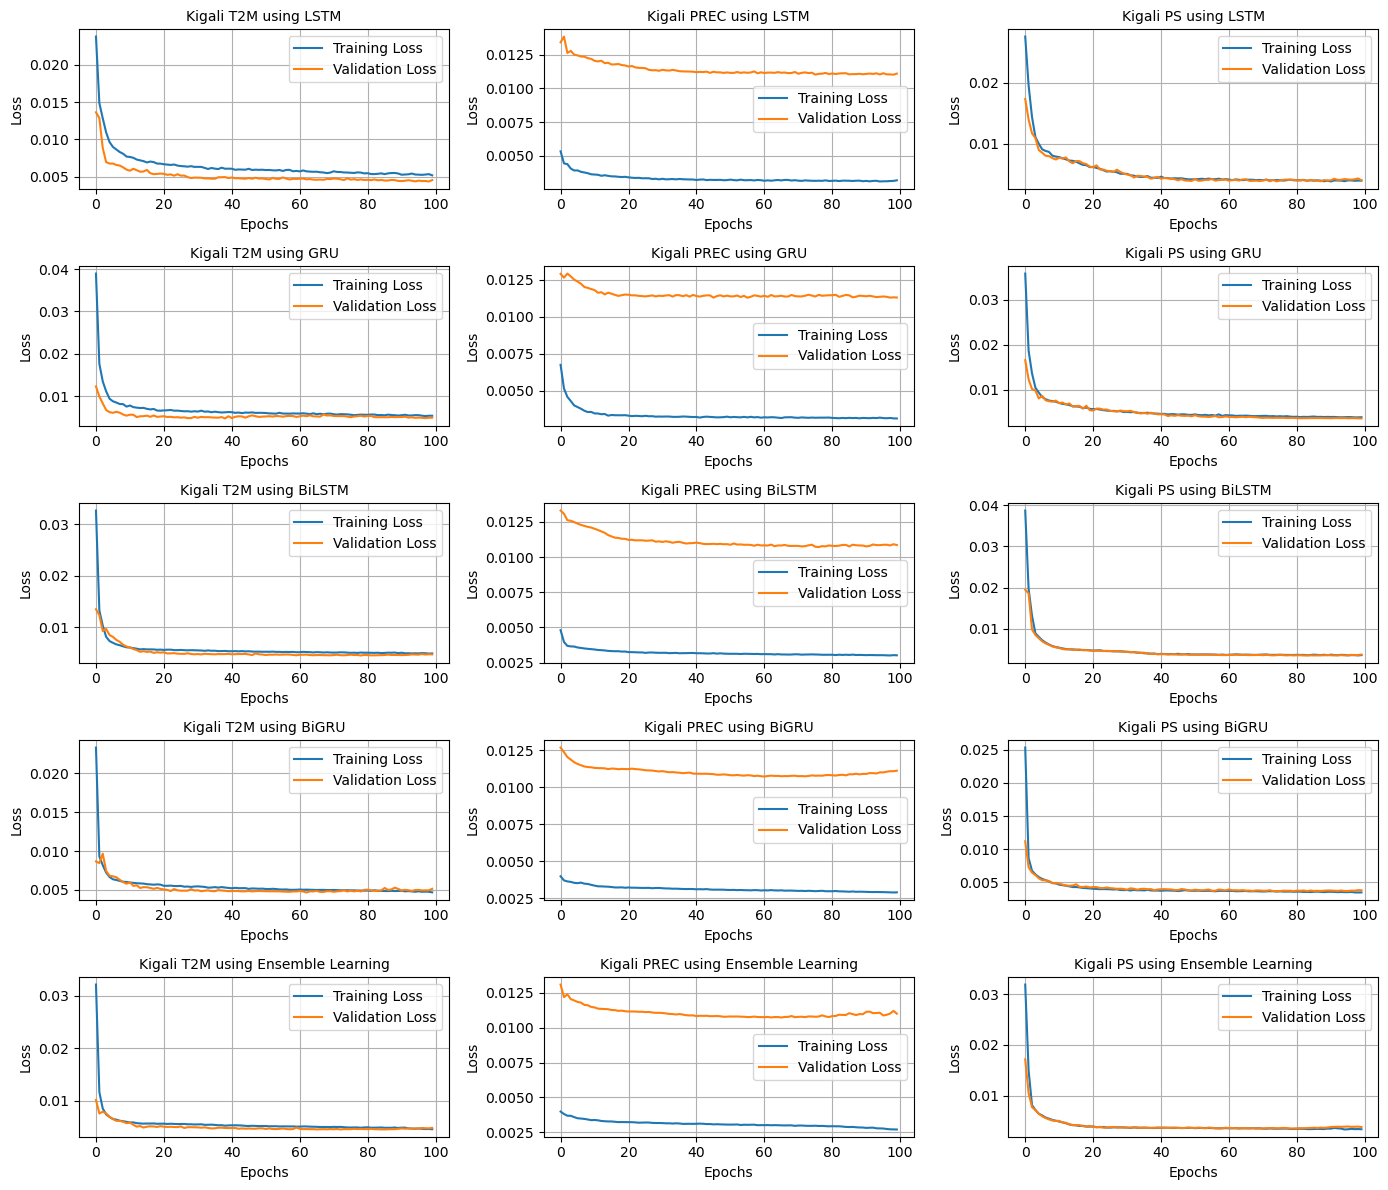

In [104]:
plot_L_curves(history_container[0],target_names,model_name,data_name[0])
# history_container[1]
# data_name[1]

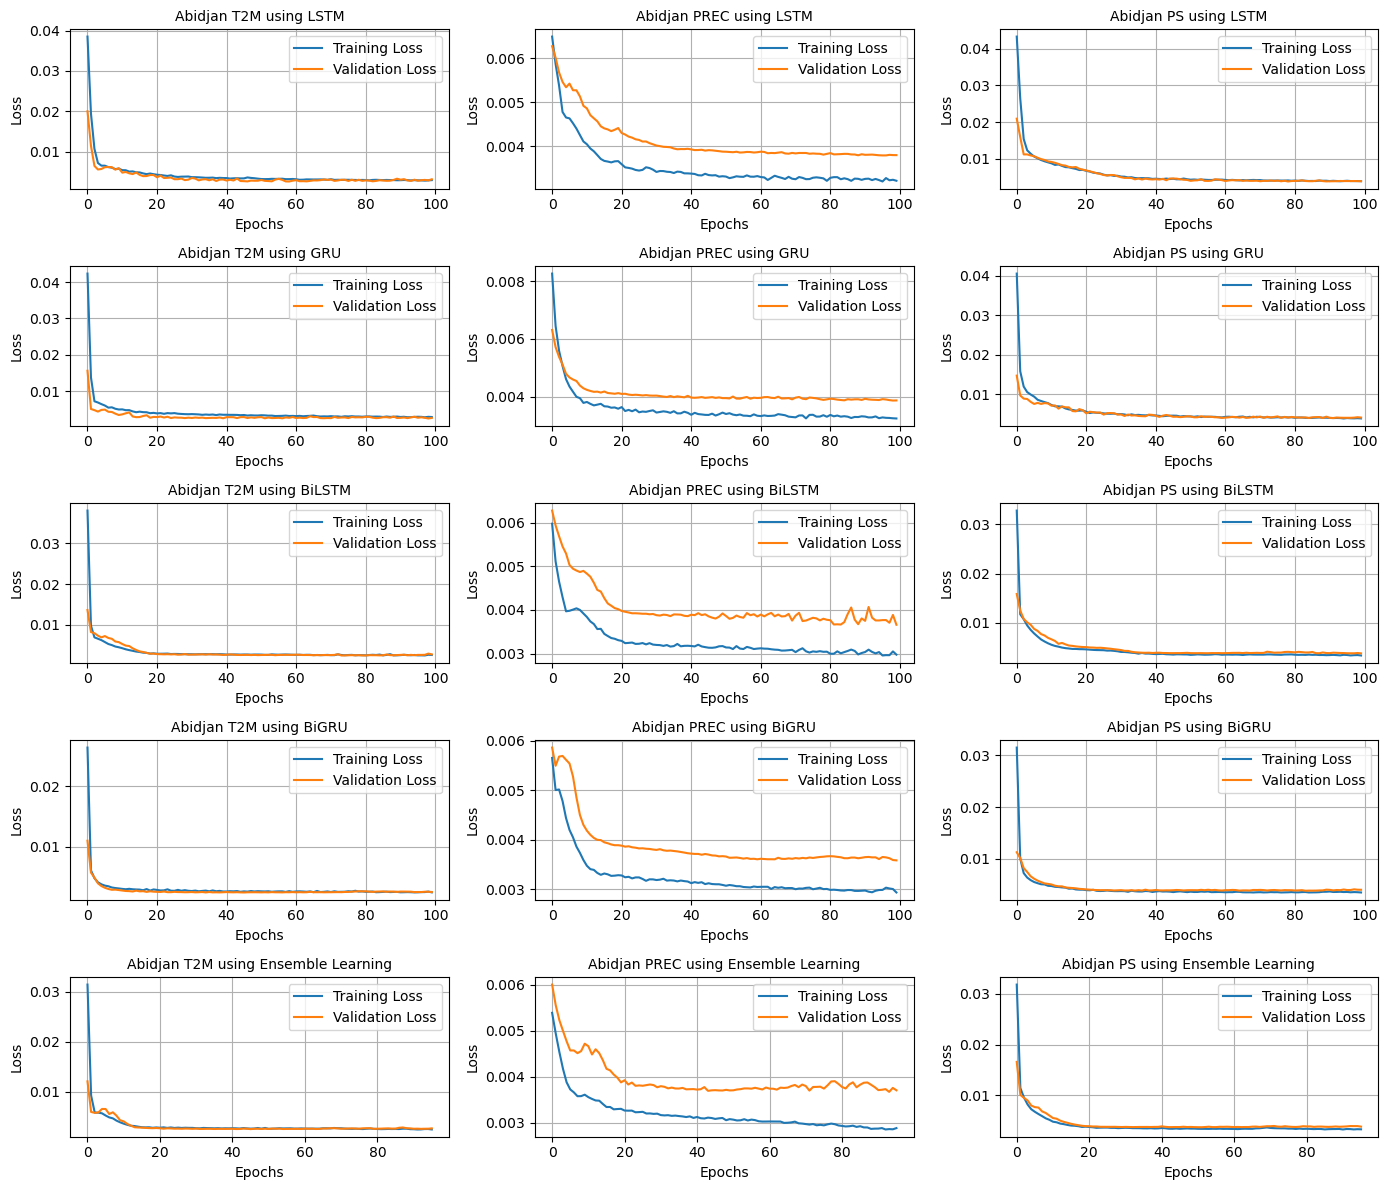

In [105]:
plot_L_curves(history_container[1],target_names,model_name,data_name[1])

In [73]:
# import torch

# # Example data: Rows are samples, columns are variables
# y_true = torch.tensor([[3.0, -0.5, 2.0, 7.0], 
#                        [4.0, 1.0, 2.0, 8.0], 
#                        [5.0, 0.5, 1.5, 7.5]])  # Actual values
# y_pred = torch.tensor([[2.5, 0.0, 2.1, 7.8], 
#                        [4.2, 1.1, 2.3, 7.6], 
#                        [4.8, 0.4, 1.8, 7.3]])  # Predicted values



# print("R^2 scores across variables:", r2_scores)


R^2 scores across variables: tensor([ 0.8350,  0.7686, -0.1400, -0.6800])


# Predictions

In [106]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_pred,y_true): 
    return torch.mean(torch.abs((y_true - y_pred) / (y_true+0.000001)),dim=0) * 100
def r2_squared(y_pred,y_true):
    # Compute mean of y_true along rows (axis=0), for each variable
    y_mean = torch.mean(y_true, dim=0)  # Shape: (variables,)
    # Compute residual sum of squares (SS_res) for each variable
    ss_res = torch.sum((y_true - y_pred) ** 2, dim=0)  # Shape: (variables,)
    # Compute total sum of squares (SS_tot) for each variable
    ss_tot = torch.sum((y_true - y_mean) ** 2, dim=0)  # Shape: (variables,)
    # Compute R^2 for each variable
    r2_scores = 1 - (ss_res / ss_tot)  # Shape: (variables,)
    # print((ss_res / ss_tot) )
    # ls=[]
    # for i in range(3):
    return r2_scores
scaler_dict={"Kigali":scaler[1],"Abidjan":scaler[0]}

import numpy as np
import pandas as pd
import torch

def evaluate_model(model_container, test_loader_list, scaler_dict, device, target_names=['T2M', 'PREC', 'PS']):
    metrics_list = []
    
    for idx, (city, models) in enumerate(model_container.items()):
        test_loader = test_loader_list[idx]  # Fetch the correct test loader
        scaler_ = scaler_dict[city]  # Use a dictionary lookup instead of hardcoding indices

        for model in models:
            model_name = model.__class__.__name__  # Get model class name as identifier
            model.to(device)
            model.eval()
            
            total_loss = 0.0
            y_true_list = []
            y_pred_list = []
            
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.squeeze().to(device)
                    outputs = model(X_batch)
                    
                    # Compute loss
                    loss = torch.nn.functional.mse_loss(outputs, y_batch)
                    total_loss += loss.item() * X_batch.size(0)
                    
                    y_true_list.append(y_batch.cpu().numpy())
                    y_pred_list.append(outputs.cpu().numpy())
            
            avg_loss = total_loss / len(test_loader.dataset)
            
            # Convert lists to NumPy arrays
            y_true = np.concatenate(y_true_list)
            y_pred = np.concatenate(y_pred_list)

            # Inverse transform
            dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2] - 3))
            actuals_padded = np.hstack([dummy_features, y_true])
            predictions_padded = np.hstack([dummy_features, y_pred])
            
            actuals_ = scaler_.inverse_transform(actuals_padded)[:, -3:]
            predictions_ = scaler_.inverse_transform(predictions_padded)[:, -3:]

            # Compute metrics for each target variable separately
            for i, var_name in enumerate(target_names):
                actual = actuals_[:, i]
                pred = predictions_[:, i]
                
                mse_ = np.mean((actual - pred) ** 2)
                rmse_ = np.sqrt(mse_)
                mae_ = np.mean(np.abs(actual - pred))
                r2_ = 1 - (np.sum((actual - pred) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

                # Handle potential division by zero in MAPE
                mask = actual != 0
                mape_ = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100 if mask.any() else np.nan

                # Store metrics for each variable
                metrics_list.append({
                    "City": city,
                    "Model": model_name,
                    "Variable": var_name,
                    "MSE": mse_,
                    "RMSE": rmse_,
                    "MAE": mae_,
                    "R²": r2_,
                    "MAPE": mape_
                })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


In [258]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_plot(model_container, test_loader_list, scaler_dict, device, target_names=['T2M', 'PREC', 'PS']):
    metrics_list = []
    
    for idx, (city, models) in enumerate(model_container.items()):
        test_loader = test_loader_list[idx]  # Fetch the correct test loader
        scaler_ = scaler_dict[city]  # Use a dictionary lookup instead of hardcoding indices

        for model in models:
            model_name = model.__class__.__name__  # Get model class name as identifier
            model.to(device)
            model.eval()
            
            y_true_list = []
            y_pred_list = []
            
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.squeeze().to(device)
                    outputs = model(X_batch)

                    y_true_list.append(y_batch.cpu().numpy())
                    y_pred_list.append(outputs.cpu().numpy())
            
            # Convert lists to NumPy arrays
            y_true = np.concatenate(y_true_list)
            y_pred = np.concatenate(y_pred_list)

            # Inverse transform
            dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2] - 3))
            actuals_padded = np.hstack([dummy_features, y_true])
            predictions_padded = np.hstack([dummy_features, y_pred])
            
            actuals_ = scaler_.inverse_transform(actuals_padded)[:, -3:]
            predictions_ = scaler_.inverse_transform(predictions_padded)[:, -3:]

            # Create a figure with subplots
            fig, axes = plt.subplots(len(target_names), 2, figsize=(12, 10))  
            fig.suptitle(f"{city} - {model_name} Predictions vs. Actuals", fontsize=14, fontweight="bold")

            for i, var_name in enumerate(target_names):
                actual = actuals_[:, i]
                pred = predictions_[:, i]

                # Compute metrics
                mse_ = np.mean((actual - pred) ** 2)
                rmse_ = np.sqrt(mse_)
                mae_ = np.mean(np.abs(actual - pred))
                r2_ = 1 - (np.sum((actual - pred) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

                # Handle potential division by zero in MAPE
                mask = actual != 0
                mape_ = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100 if mask.any() else np.nan

                # Store metrics
                metrics_list.append({
                    "City": city,
                    "Model": model_name,
                    "Variable": var_name,
                    "MSE": mse_,
                    "RMSE": rmse_,
                    "MAE": mae_,
                    "R²": r2_,
                    "MAPE": mape_
                })

                # --- Subplot 1: Line Plot ---
                ax1 = axes[i, 0]
                ax1.plot(actual, label="Actual", color="blue", alpha=0.7)
                ax1.plot(pred, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
                ax1.set_title(f"{var_name} - Time Series")
                ax1.set_xlabel("Time Step")
                ax1.set_ylabel(var_name)
                ax1.legend()

                # --- Subplot 2: Histogram ---
                ax2 = axes[i, 1]
                sns.histplot(actual, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=ax2)
                sns.histplot(pred, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=ax2)
                ax2.set_title(f"{var_name} - Distribution")
                ax2.set_xlabel(var_name)
                ax2.set_ylabel("Frequency")
                ax2.legend()

            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
            plt.show()
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


In [108]:
# # metrics_dic={"Abidjan":[]}
# all_metrics={"Kigali":{"lstm":[],"gru":[],"bilstm":[],"bigru":[],"ens_learn":[]},"Abidjan":{"lstm":[],"gru":[],"bilstm":[],"bigru":[],"ens_learn":[]}}
# test_loaders=[Kgl_test_loader,Abj_test_loader]
# for idx_dt, (idx_names, models_names)  in enumerate(all_metrics.items()):
#     for idx_m,(names, metrics_list) in enumerate(models_names .items()):
#         # print(evaluate_model(models[idx_m], test_loaders[idx_dt]))
#         metrics_list.append(evaluate_model(models[idx_m], test_loaders[idx_dt],scaler[idx_dt]))
#         # print(names,metrics_list)
#     # for mdl in models:
#     # break 
# all_metrics  
test_loader_list=[Kgl_test_loader,Abj_test_loader]
all_metrics=evaluate_model(model_container, test_loader_list, scaler_dict, device)
all_metrics.to_csv("all_metrics_rnn.csv")

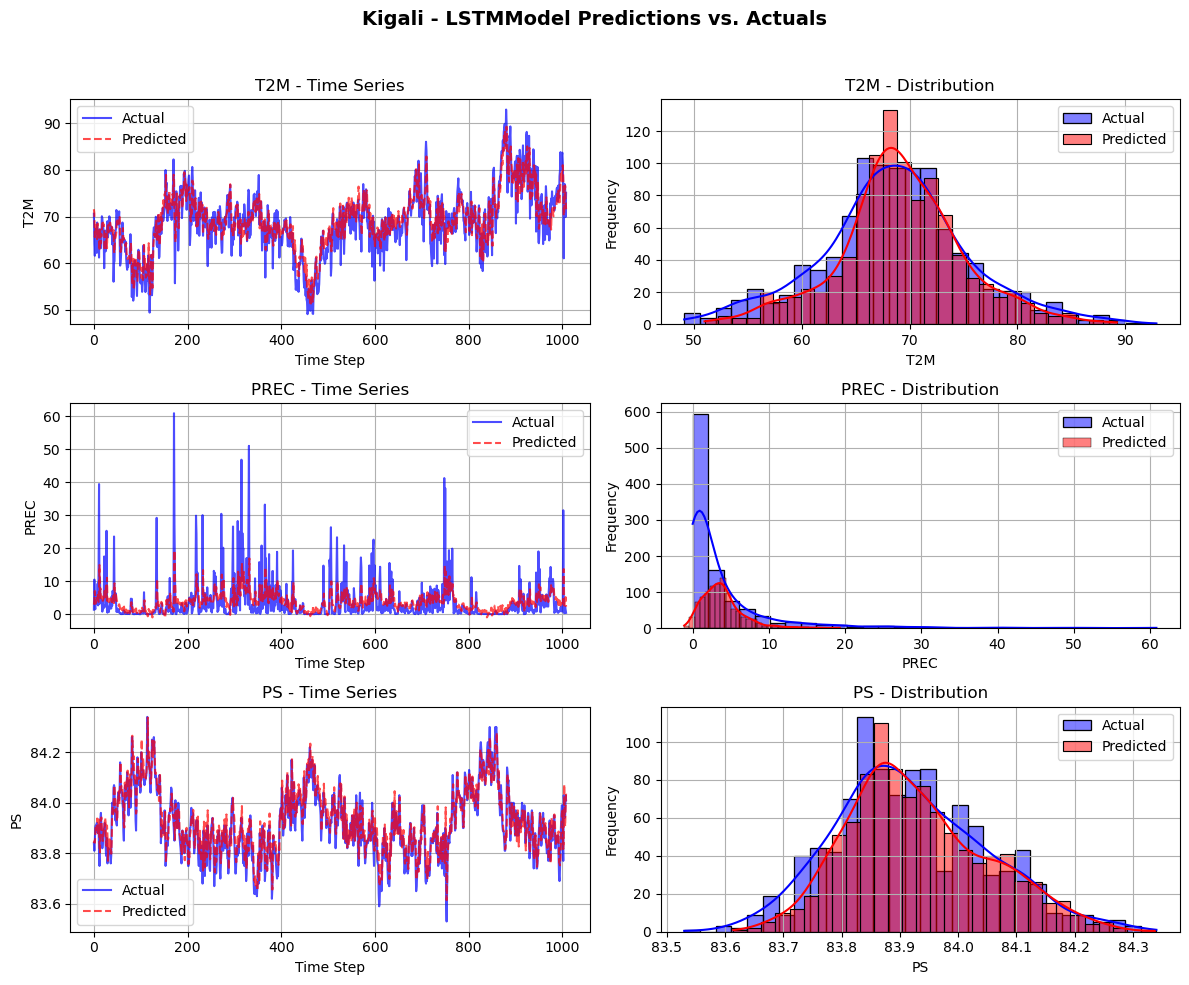

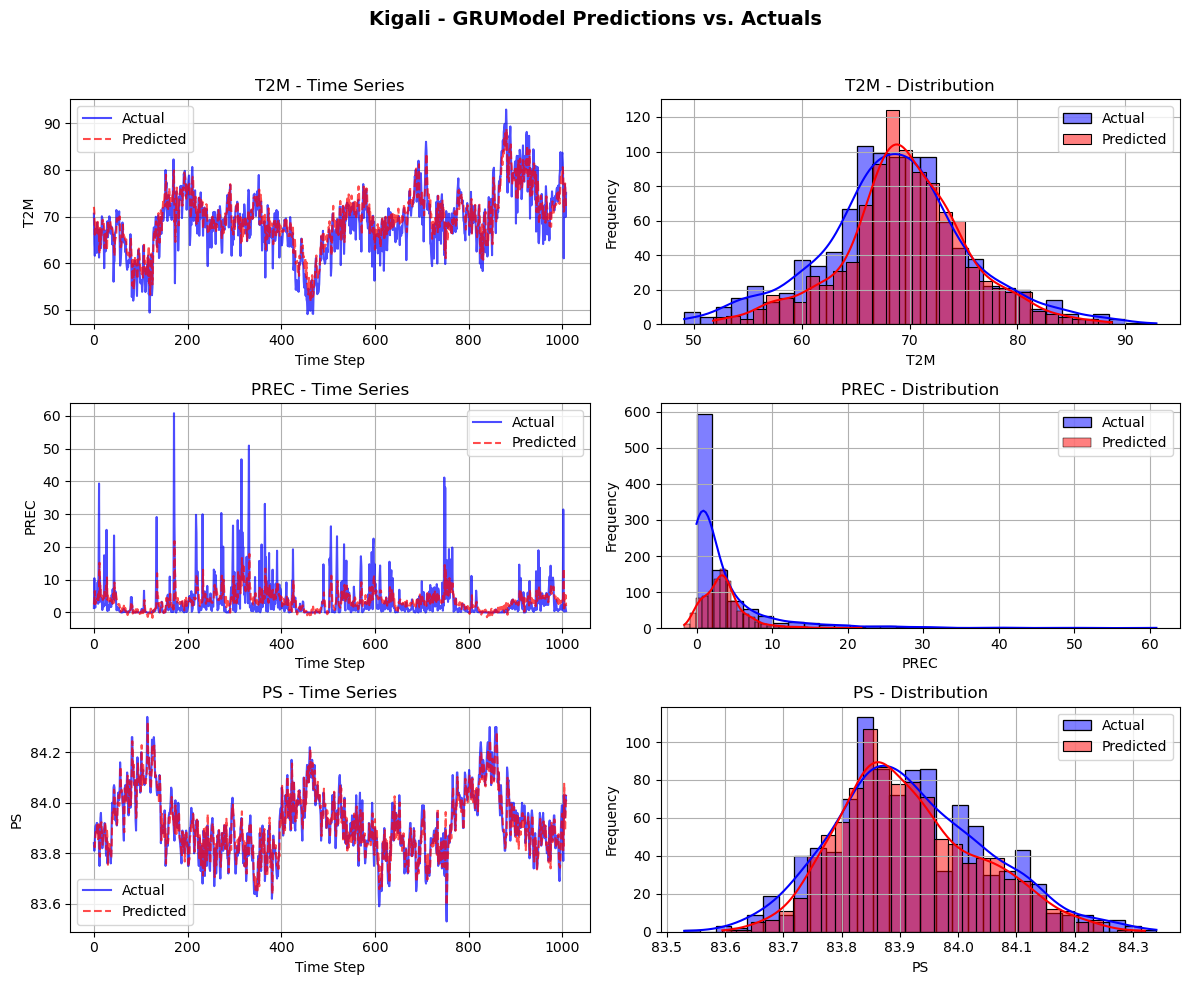

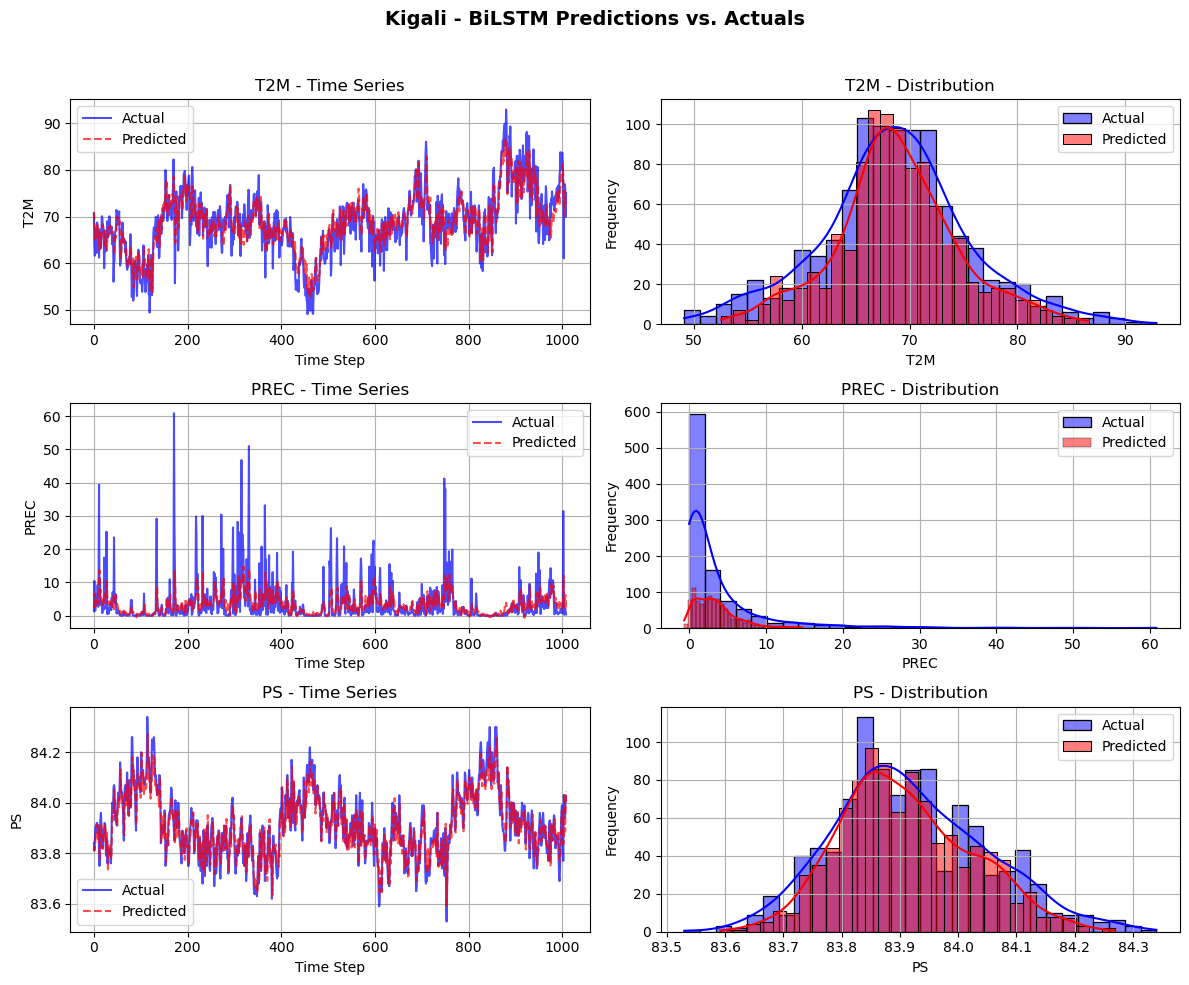

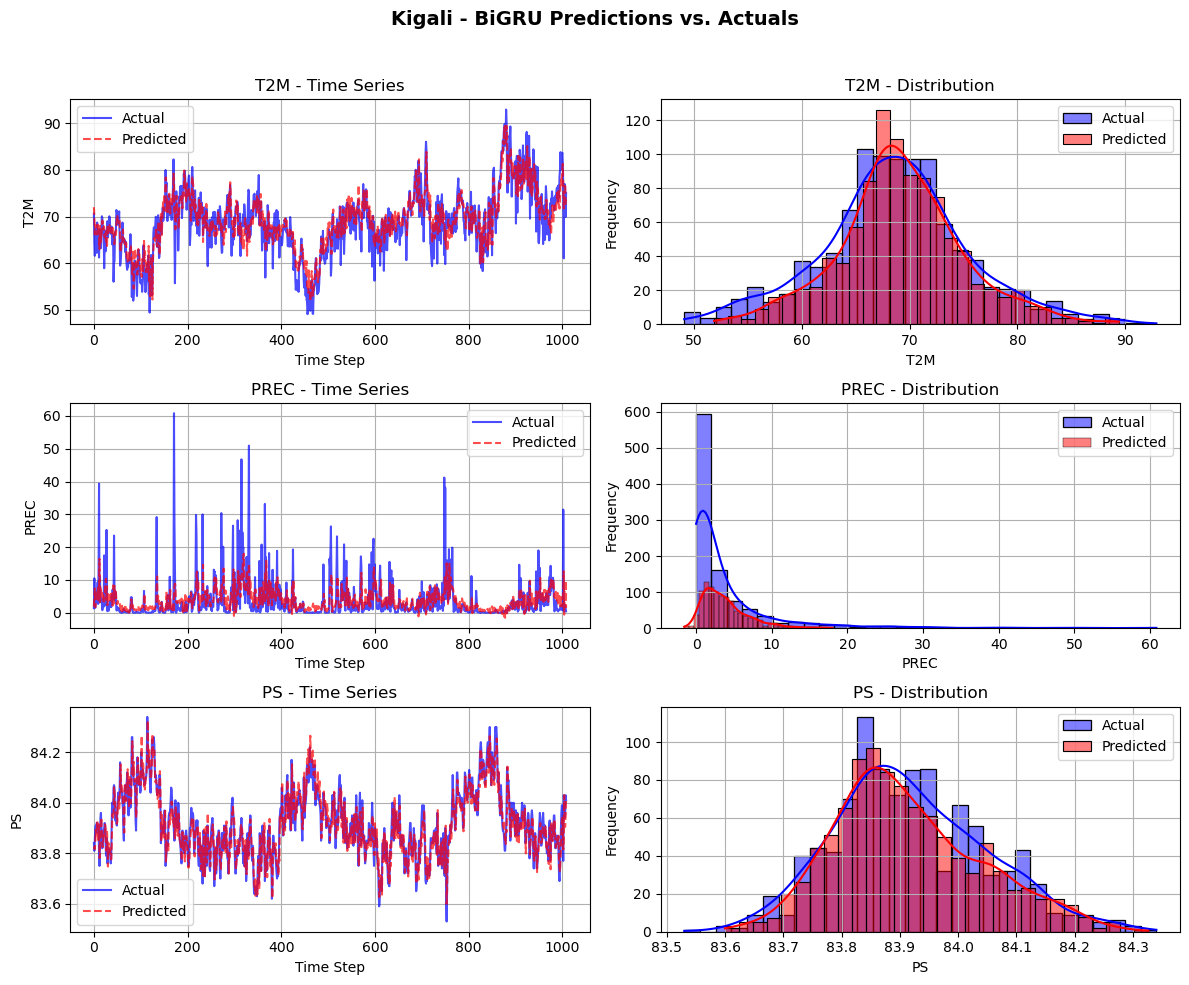

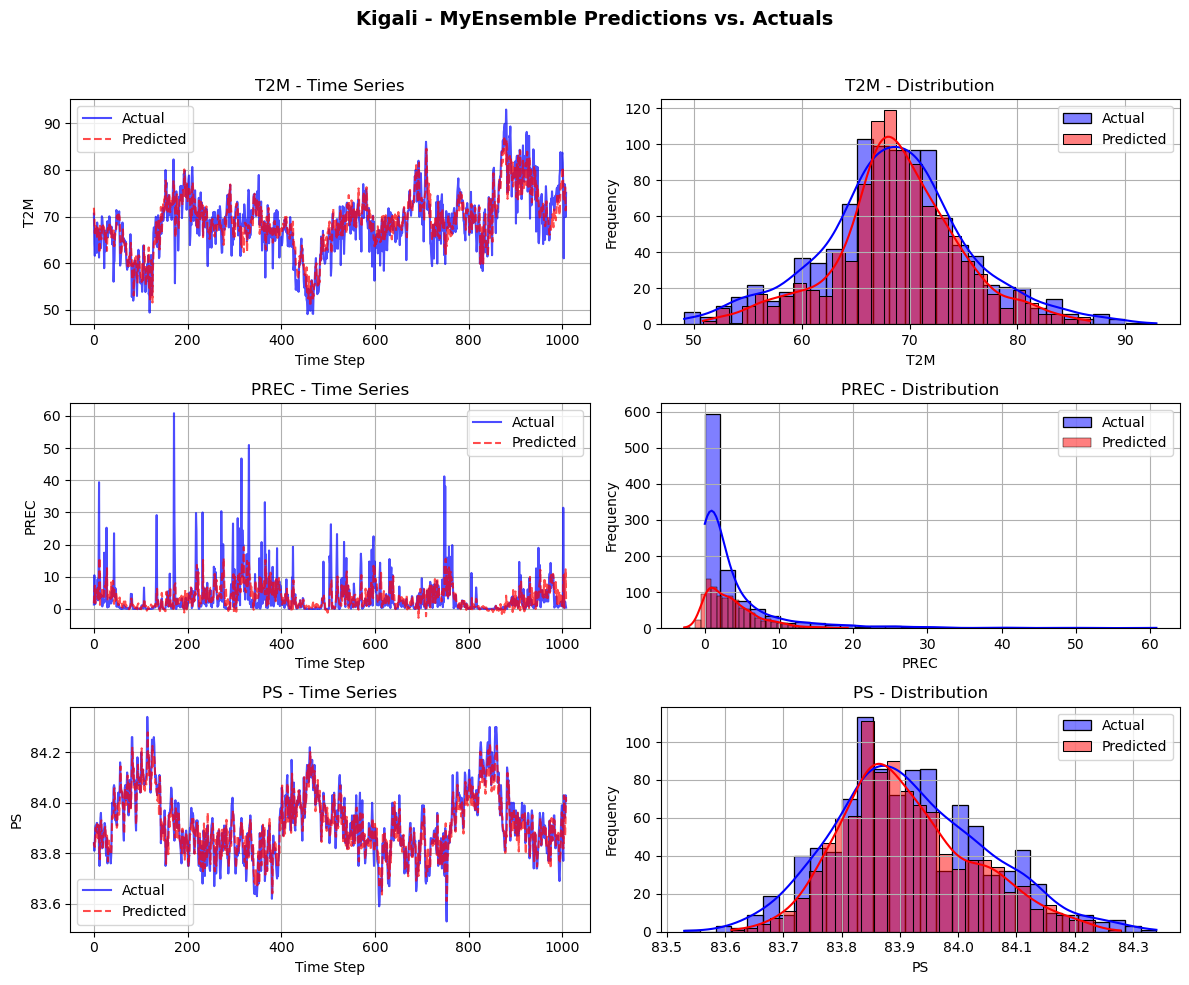

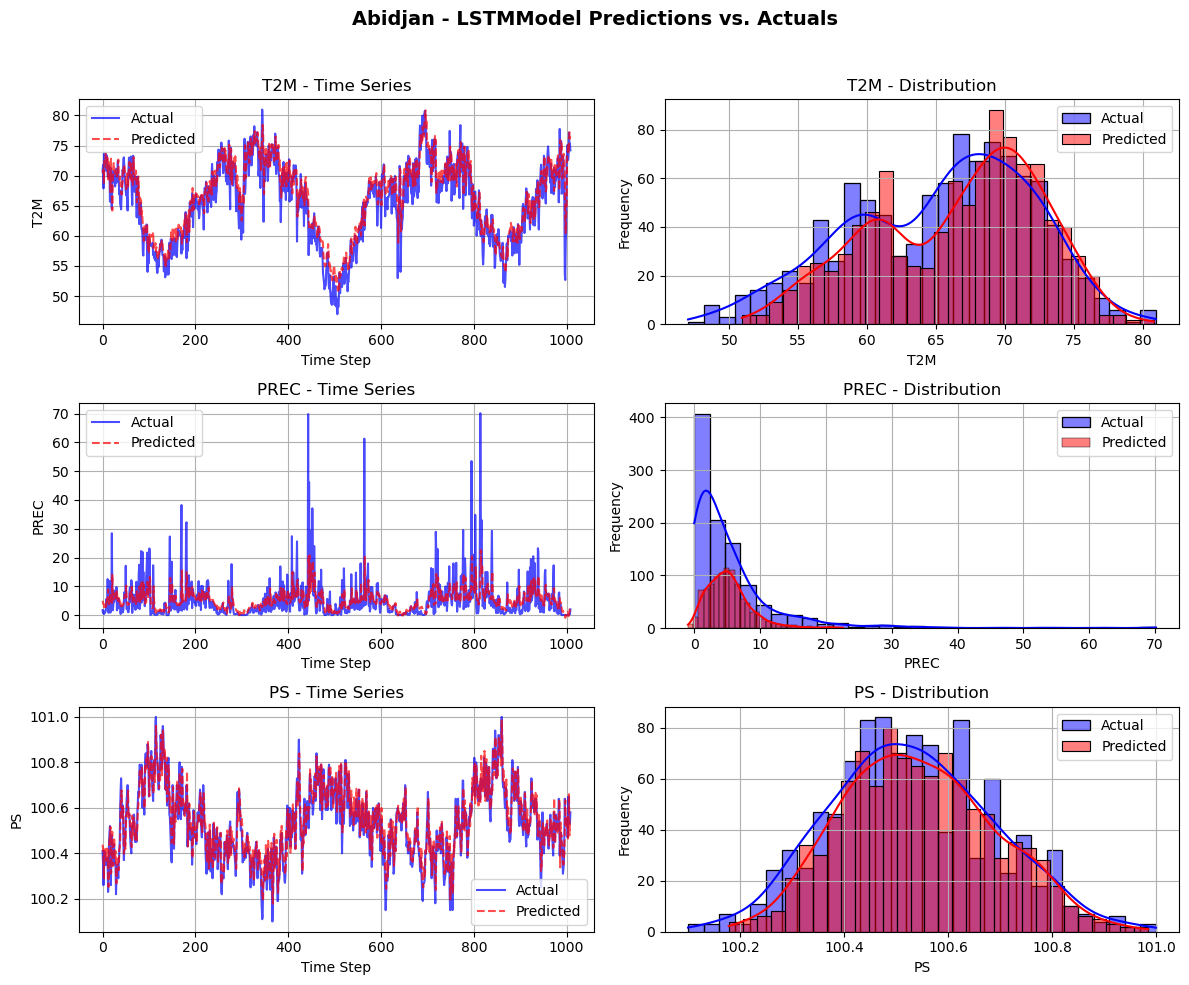

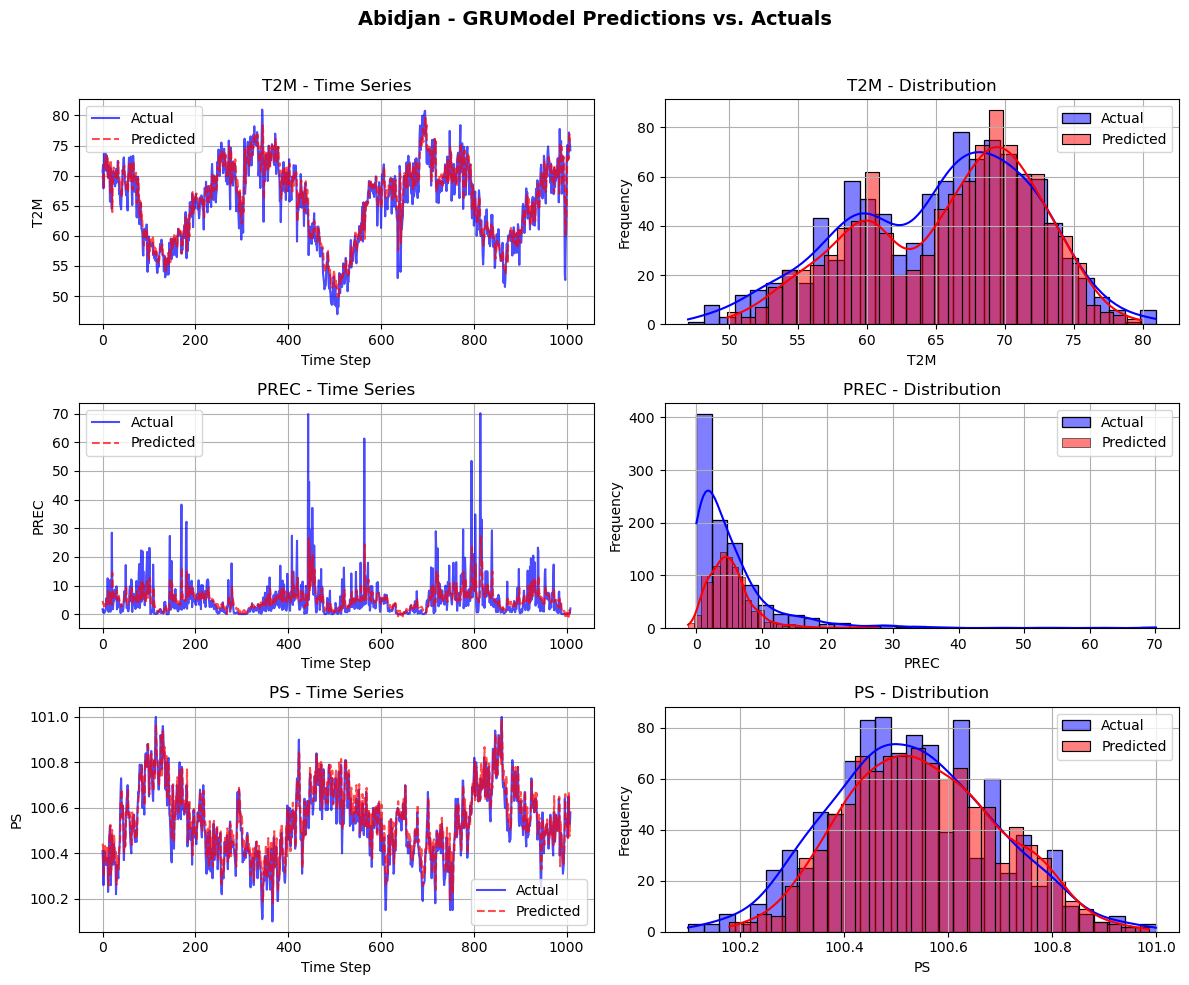

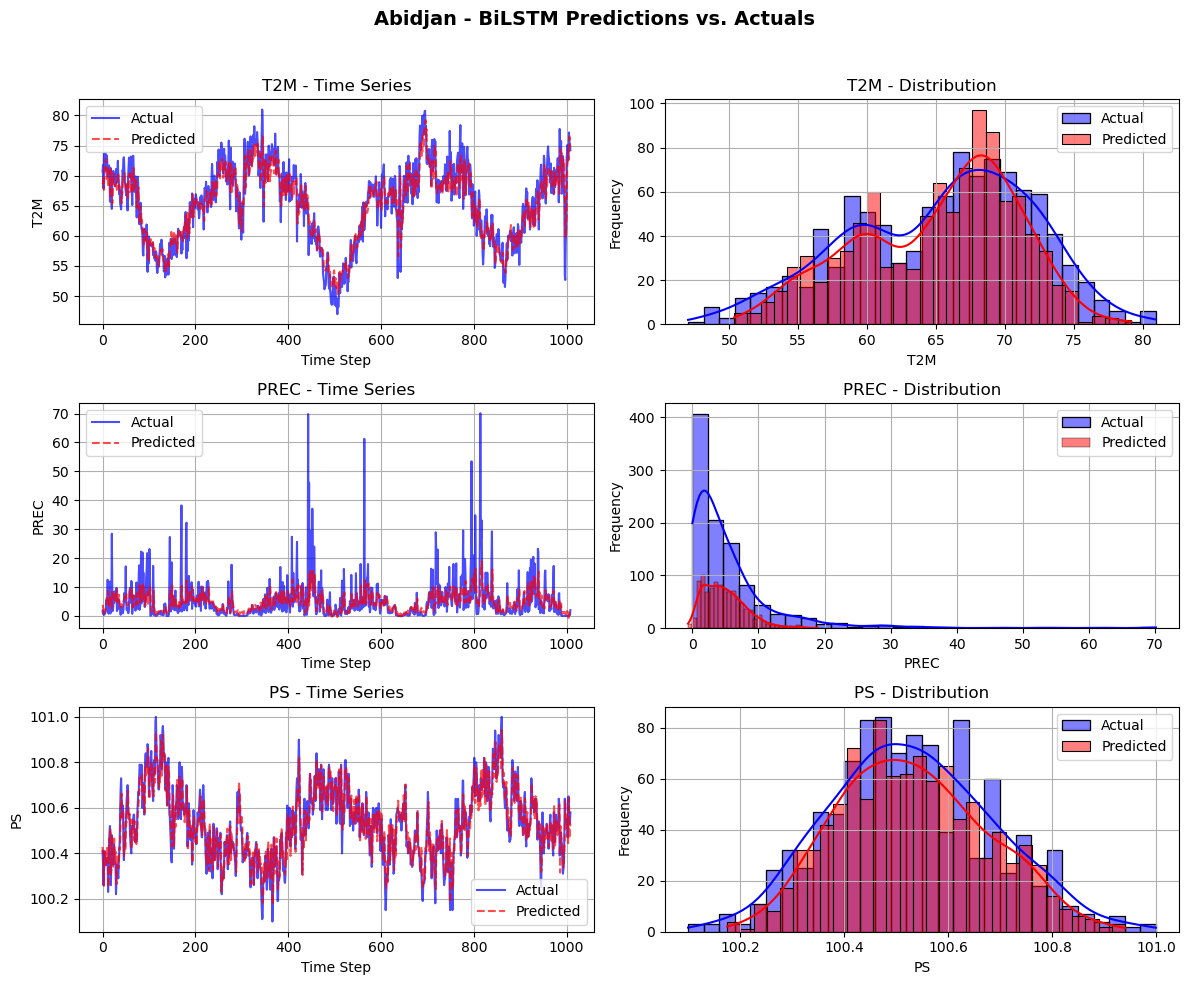

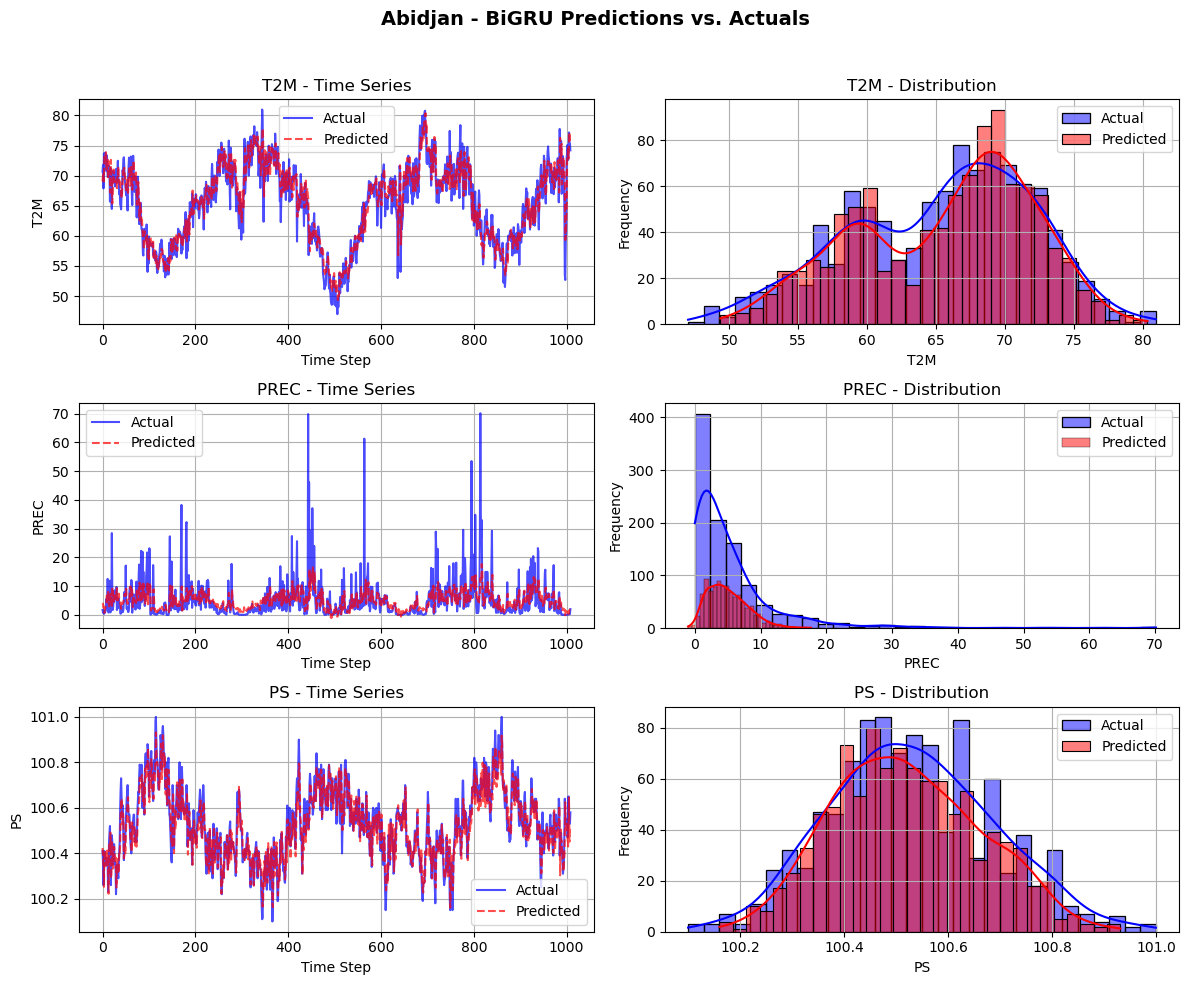

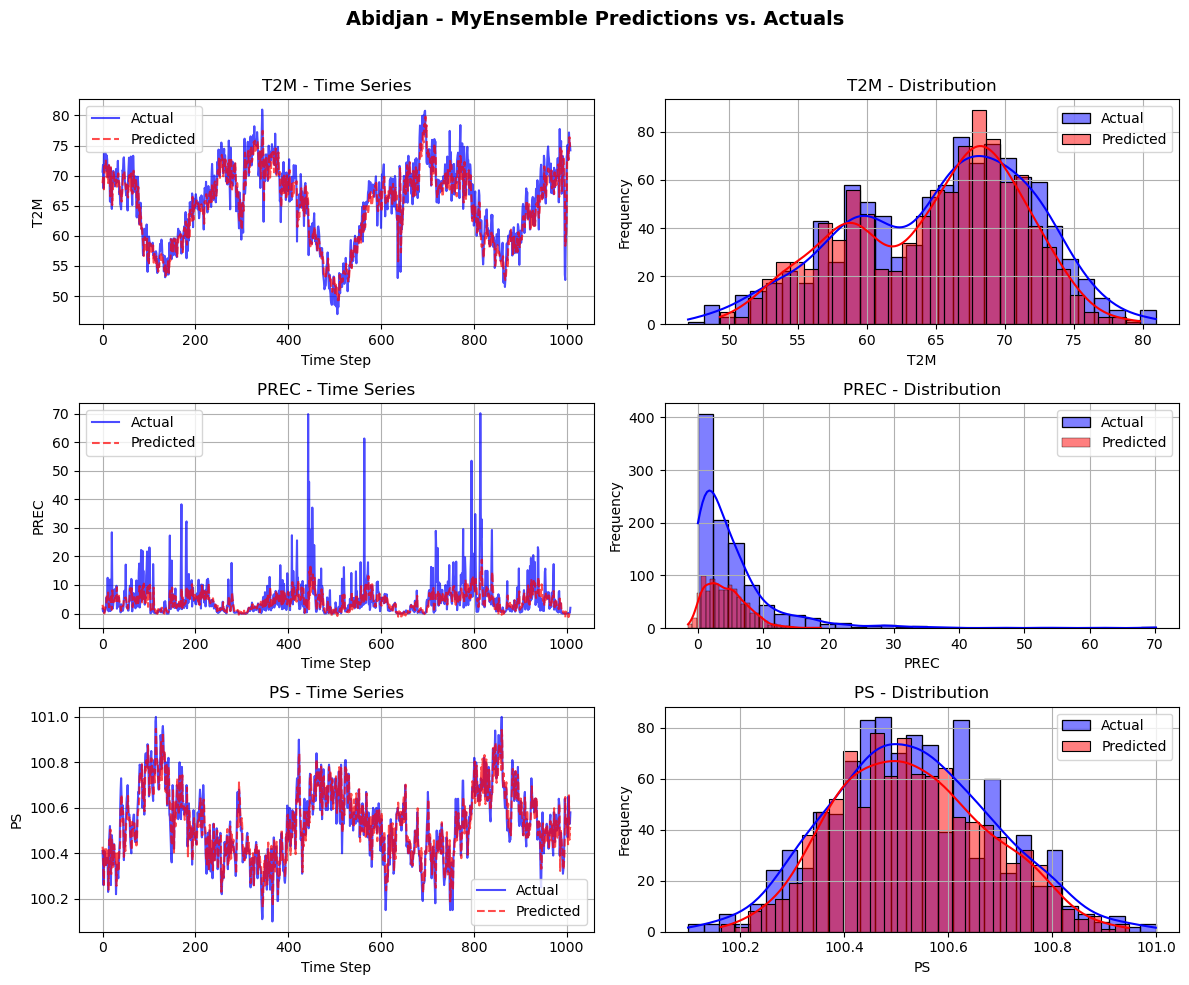

City       Model Variable        MSE      RMSE       MAE        R²  \
0    Kigali   LSTMModel      T2M  11.822734  3.438420  2.624181  0.755366   
1    Kigali   LSTMModel     PREC  29.130923  5.397307  3.012142  0.224210   
2    Kigali   LSTMModel       PS   0.002557  0.050567  0.039916  0.850713   
3    Kigali    GRUModel      T2M  12.603342  3.550119  2.711434  0.739214   
4    Kigali    GRUModel     PREC  29.232484  5.406707  2.903792  0.221505   
5    Kigali    GRUModel       PS   0.002354  0.048517  0.038173  0.862572   
6    Kigali      BiLSTM      T2M  12.097596  3.478160  2.678822  0.749679   
7    Kigali      BiLSTM     PREC  28.711726  5.358332  2.748771  0.235373   
8    Kigali      BiLSTM       PS   0.002482  0.049824  0.039423  0.855071   
9    Kigali       BiGRU      T2M  12.410085  3.522795  2.705414  0.743213   
10   Kigali       BiGRU     PREC  29.239320  5.407339  2.993914  0.221323   
11   Kigali       BiGRU       PS   0.002551  0.050510  0.040129  0.851054   
12   Kigali  MyEnsemble      T2M  12.529595  3.539717  2.720868  0.740740   
13   Kigali  MyEnsemble     PREC  30.298629  5.504419  2.940118  0.193112   
14   Kigali  MyEnsemble       PS   0.002618  0.051170  0.040016  0.847133   
15  Abidjan   LSTMModel      T2M   7.611276  2.758854  2.102978  0.826935   
16  Abidjan   LSTMModel     PREC  36.134448  6.011194  3.291066  0.259003   
17  Abidjan   LSTMModel       PS   0.003643  0.060354  0.048553  0.853341   
18  Abidjan    GRUModel      T2M   6.350870  2.520093  1.900995  0.855594   
19  Abidjan    GRUModel     PREC  36.621408  6.051562  3.261811  0.249017   
20  Abidjan    GRUModel       PS   0.003946  0.062817  0.050555  0.841124   
21  Abidjan      BiLSTM      T2M   6.287707  2.507530  1.919773  0.857031   
22  Abidjan      BiLSTM     PREC  35.678063  5.973112  3.121464  0.268362   
23  Abidjan      BiLSTM       PS   0.003511  0.059250  0.047372  0.858659   
24  Abidjan       BiGRU      T2M   6.135658  2.477026  1.864558  0.860488   
25  Abidjan       BiGRU     PREC  35.635983  5.969588  3.217228  0.269225   
26  Abidjan       BiGRU       PS   0.003681  0.060669  0.048159  0.851806   
27  Abidjan  MyEnsemble      T2M   6.251779  2.500356  1.909425  0.857847   
28  Abidjan  MyEnsemble     PREC  37.292001  6.106718  3.057153  0.235265   
29  Abidjan  MyEnsemble       PS   0.003536  0.059464  0.047588  0.857636   

          MAPE  
0     3.921739  
1   860.479088  
2     0.047573  
3     4.073715  
4   712.701114  
5     0.045488  
6     3.977455  
7   544.307583  
8     0.046972  
9     4.043611  
10  812.718575  
11    0.047816  
12    4.034015  
13  540.108556  
14    0.047682  
15    3.309554  
16  341.144827  
17    0.048304  
18    2.953477  
19  353.993386  
20    0.050299  
21    2.952153  
22  320.310021  
23    0.047123  
24    2.883825  
25  393.233520  
26    0.047899  
27    2.921451  
28  217.699603  
29    0.047336

In [238]:
# # metrics_dic={"Abidjan":[]}
# all_metrics={"Kigali":{"lstm":[],"gru":[],"bilstm":[],"bigru":[],"ens_learn":[]},"Abidjan":{"lstm":[],"gru":[],"bilstm":[],"bigru":[],"ens_learn":[]}}
# test_loaders=[Kgl_test_loader,Abj_test_loader]
# for idx_dt, (idx_names, models_names)  in enumerate(all_metrics.items()):
#     for idx_m,(names, metrics_list) in enumerate(models_names .items()):
#         # print(evaluate_model(models[idx_m], test_loaders[idx_dt]))
#         metrics_list.append(evaluate_model(models[idx_m], test_loaders[idx_dt],scaler[idx_dt]))
#         # print(names,metrics_list)
#     # for mdl in models:
#     # break 
# all_metrics       
evaluate_and_plot(model_container, test_loader_list, scaler_dict, device)

In [110]:
# result=pd.DataFrame([metrics_lstm,metrics_gru,metrics_bilstm,metrics_bigrus],columns=['MAPE (%)','R²','MAE','RMSE','MSE'],index=['LSTM','GRU','BiLSTM','BiGRU'])
# result


### Kolmogorov Arnold Networks

In [135]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1) # Create n grid for n features
            .contiguous() #ensures that the tensor is stored in memory in a contiguous manner, which improves performance for operations that require sequential memory access.
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )
# We don't know out_features (Guess:2*in_features +1), the reason behind the per-batch structuration of self.spline_weight and the structuration of self.base_weight
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.reset_parameters()
# The parameters abbove are not really known
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                ) # Provide initial best values to the self.spline_weight (either scaled or not )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).
        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        # print("A shape:", A.shape)  # Should be (batch, n, m)
        # print("B shape:", B.shape)  # Should be (batch, n, out_features)

        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )
    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [261]:
# scaler = MinMaxScaler(feature_range=(0,1))
def Make_tidydata_for_kan(data,scaler,data_type="full"):
    if data_type=="full":
        data= data.sort_index()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        # print("data:",data.shape)
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return [Xy_train,Xy_val,Xy_test]


In [262]:


def data_loading(Xy):
    # Define the data 
    X,y=Xy.values[:,:-1],Xy.values[:,-1]
    X = torch.tensor(X, dtype=torch.float32)  # Convert to float32
    y = torch.tensor(y, dtype=torch.float32)  # Convert to float32
    # Create DataLoader
    batch_size = 64
    _dataset = TensorDataset(X, y.reshape(-1, 1))
    _loader = DataLoader(_dataset, batch_size=batch_size, shuffle=True)
    return  _loader 

In [196]:
os.path.exists("/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models")
# os.getcwd()

True

In [293]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

var_to_pred = ['T2M', 'PREC', 'PS']

def train_test_loop_per_var(data, epochs,scaler, city="Kigali",layers_hidden=[9, 19, 1]):
    models = {}
    training_losses = {var: [] for var in var_to_pred}
    val_losses = {var: [] for var in var_to_pred}
    test_loaders = {var: [] for var in var_to_pred}
    dict_dates={var: [] for var in var_to_pred}
    for idx, var_name in enumerate(var_to_pred):
        # Work on a copy to avoid modifying the original data
        data_copy = data.copy()
        target_col = data_copy.pop(var_name)
        data_copy.insert(len(data_copy.columns), var_name, target_col)
        # 
        dates=data_copy.index.astype(str).tolist()
        # Create loaders
        list_data = Make_tidydata_for_kan(data_copy,scaler[idx])
        dict_dates[var_name].extend(Make_tidydata_for_kan(dates, scaler[idx],data_type="dates"))
        # train_loader, val_loader, test_loader = data_loading(np.array(list_data))
        train_loader, val_loader, test_loader = [data_loading(data) for data in list_data]

        test_loaders[var_name]=test_loader
        # Model Definition
        Kan_network = KAN(layers_hidden=layers_hidden).to(torch.float32)

        # Define loss and optimizer
        criterion = nn.MSELoss()  # Regression loss
        optimizer = torch.optim.Adam(Kan_network.parameters(), lr=0.001)
        Kan_network.train()
        # Epoch loop
        for epoch in range(epochs):
            epoch_train_loss = 0
            epoch_val_loss = 0

            # Training loop
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = Kan_network(X_batch, update_grid=(epoch == 0))  # Only update grid on first epoch
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            loss_cum_train = epoch_train_loss / len(train_loader)
            training_losses[var_name].append(loss_cum_train)

            # Validation loop
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred_ = Kan_network(X_batch, update_grid=False)  # No need to update grid in validation
                    loss = criterion(y_pred_, y_batch)
                    epoch_val_loss += loss.item()
                
                loss_cum_val = epoch_val_loss / len(val_loader)
                val_losses[var_name].append(loss_cum_val)

            if epoch % 50 == 0:
                print(f"Epoch [{epoch}/{epochs}], Variable: {var_name} MSE Train Loss: {loss_cum_train:.4f}")
                print(f"MSE Validation Loss: {loss_cum_val:.4f}")

        print(f"Training complete for {var_name} {city}! 🚀")
        models[var_name] = Kan_network
        torch.save(Kan_network,f"/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models/{city}_Kan_network_{var_name}.pt")
    return models,test_loaders, training_losses, val_losses,dict_dates


In [294]:
# Scaler
scaler1 = [MinMaxScaler(feature_range=(0,1)) for _ in [0,1,2]]
scaler2 = [MinMaxScaler(feature_range=(0,1)) for _ in [0,1,2]]
# Training for Abidjan data
data_Abj, epochs=Abj_dt,100
models_Abj,test_loaders_Abj, training_losses_Abj, val_losses_Abj,dict_dates_Abj=train_test_loop_per_var(data_Abj, epochs,scaler1, city="Abidjan",layers_hidden=[9, 19, 1])
# Training for Kigali data
data_Kgl=Kgl_dt
models_Kgl,test_loaders_Kgl, training_losses_Kgl, val_losses_Kgl,dict_dates_Kgl=train_test_loop_per_var(data_Kgl, epochs,scaler2,city="Kigali", layers_hidden=[9, 19, 1])

Epoch [0/100], Variable: T2M MSE Train Loss: 0.1269
MSE Validation Loss: 0.0511
Epoch [50/100], Variable: T2M MSE Train Loss: 0.0000
MSE Validation Loss: 0.0002
Training complete for T2M! 🚀
Epoch [0/100], Variable: PREC MSE Train Loss: 0.0047
MSE Validation Loss: 0.0062
Epoch [50/100], Variable: PREC MSE Train Loss: 0.0020
MSE Validation Loss: 0.0040
Training complete for PREC! 🚀
Epoch [0/100], Variable: PS MSE Train Loss: 0.1723
MSE Validation Loss: 0.0664
Epoch [50/100], Variable: PS MSE Train Loss: 0.0085
MSE Validation Loss: 0.0167
Training complete for PS! 🚀
Epoch [0/100], Variable: T2M MSE Train Loss: 0.2147
MSE Validation Loss: 0.0461
Epoch [50/100], Variable: T2M MSE Train Loss: 0.0000
MSE Validation Loss: 0.0000
Training complete for T2M! 🚀
Epoch [0/100], Variable: PREC MSE Train Loss: 0.0038
MSE Validation Loss: 0.0132
Epoch [50/100], Variable: PREC MSE Train Loss: 0.0017
MSE Validation Loss: 0.0107
Training complete for PREC! 🚀
Epoch [0/100], Variable: PS MSE Train Loss: 0.1

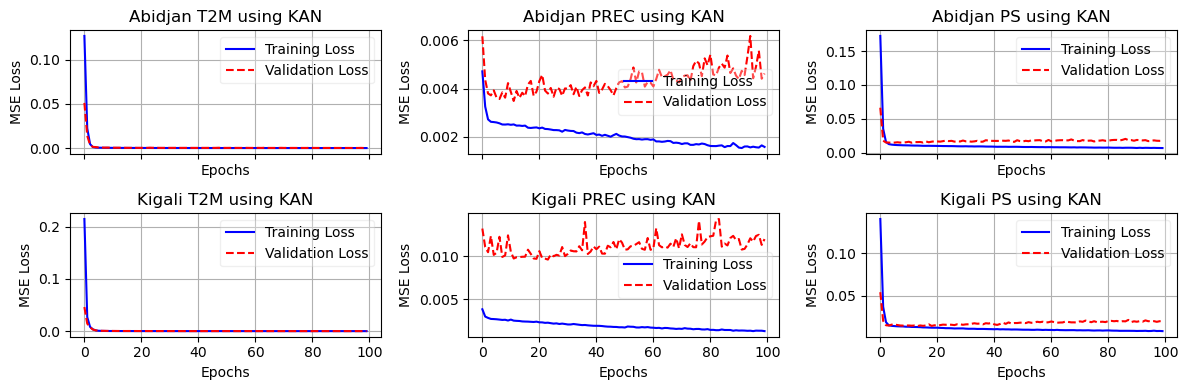

In [295]:
import matplotlib.pyplot as plt

# Define city-specific data
cities = ["Abidjan", "Kigali"]
training_losses = [training_losses_Abj, training_losses_Kgl]
val_losses = [val_losses_Abj, val_losses_Kgl]

# Create subplots
fig, axes = plt.subplots( len(cities),len(var_to_pred), figsize=(12, 4), sharex=True, sharey=False)

for row, (city, train_loss, val_loss) in enumerate(zip(cities, training_losses, val_losses)):
    for col, var in enumerate(var_to_pred):
        ax = axes[row, col]
        
        # Plot training & validation loss
        ax.plot(train_loss[var], label="Training Loss", color="blue")
        ax.plot(val_loss[var], label="Validation Loss", color="red", linestyle="--")
        
        ax.set_title(f"{city} {var} using KAN")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("MSE Loss")
        ax.legend(framealpha=0.3)
        # Adjust text transparency
        if var=="PREC" and city in ["Kigali","Abidjan"]:
            ax.legend(framealpha=0.3,loc="center right")
            # legend = ax.legend(framealpha=0.3)  # Set background transparency
            # for text in legend.get_texts():
            #     text.set_alpha(0.9)  
        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [240]:
# models_Kgl

In [298]:
dict_m={"Abidjan":[models_Abj,test_loaders_Abj,dict_dates_Abj], "Kigali": [models_Kgl,test_loaders_Kgl, dict_dates_Kgl]}
cities = ["Abidjan", "Kigali"]
scalers=[scaler1,scaler2]

In [300]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def kan_prediction_plots(dict_m, cities,scalers,var_to_pred = ['T2M', 'PREC', 'PS']):
    metrics_list = []
    for idx_d,city in enumerate(cities):
         # Create subplots for visualization
        scaler=scalers[idx_d]
        fig, axes = plt.subplots( 3,2, figsize=(12, 10))
        fig.suptitle(f"{city} KAN Predictions vs. Actuals ", fontsize=14, fontweight="bold")
        for col, var_name in enumerate(var_to_pred):
            model = dict_m[city][0][var_name]
            model.eval()
            test_loader = dict_m[city][1][var_name]
            dates = dict_m[city][2][var_name][-1]
            
            y_true_list = []
            y_pred_list = []
            
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch, y_batch.squeeze()
                    outputs = model(X_batch)

                    y_true_list.append(y_batch.cpu().numpy())
                    y_pred_list.append(outputs.cpu().numpy())

            # Convert lists to NumPy arrays
            y_true = np.concatenate(y_true_list)
            y_pred = np.concatenate(y_pred_list)
            # print(X_batch.shape)
            # Inverse transform
            dummy_features = np.zeros((y_true.shape[0], X_batch.shape[1] ))
            actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
            predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])

            actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1]
            predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1]
            # print( predictions_ [:10],actuals_ [:10]) 
            # Compute metrics
            mse_ = np.mean((actuals_ - predictions_) ** 2)
            rmse_ = np.sqrt(mse_)
            mae_ = np.mean(np.abs(actuals_ - predictions_))
            r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

            mask = actuals_ != 0
            mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

            # Store metrics
            metrics_list.append({
                "City": city,
                "Model": "KAN",
                "Variable": var_name,
                "MSE": mse_,
                "RMSE": rmse_,
                "MAE": mae_,
                "R²": r2_,
                "MAPE": mape_
            })

           
            

            # --- Subplot 1: Line Plot ---
            axes[col,0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
            axes[col,0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
            axes[col,0].set_title(f"{var_name} - Time Series")
            axes[col,0].set_xlabel("Time Step")
            axes[col,0].set_ylabel(var_name)
            axes[col,0].legend(framealpha=0.5)
            axes[col,0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
            axes[col,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
            # axes[col, 0].tick_params(axis="x", rotation=45)  # ✅ Correct


            # --- Subplot 2: Histogram ---
            sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[col,1])
            sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[col,1])
            axes[col,1].set_title(f"{var_name} - Distribution")
            axes[col,1].set_xlabel(var_name)
            axes[col,1].set_ylabel("Frequency")
            axes[col,1].legend(framealpha=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
        plt.show()
        # print(idx_d)
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


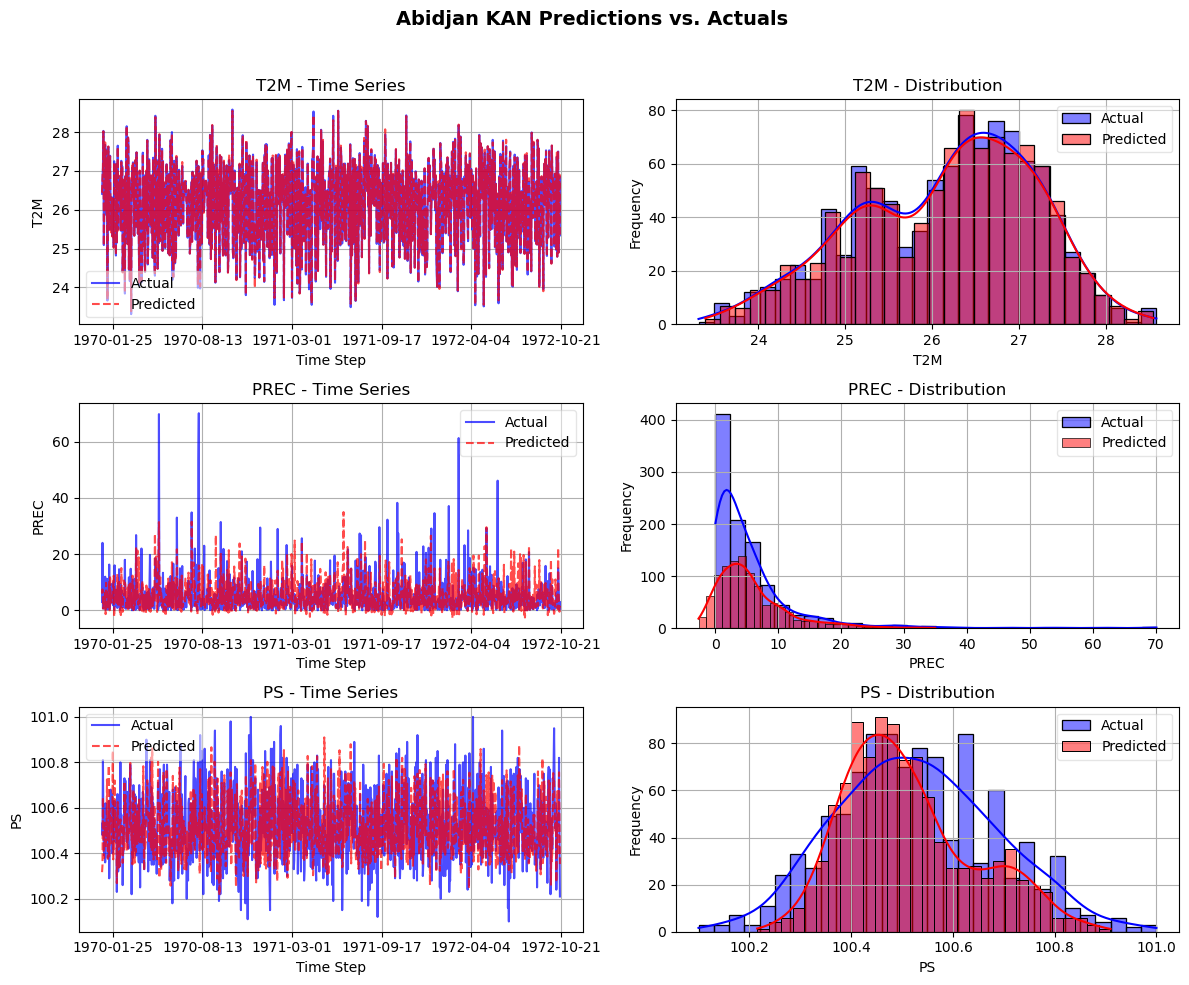

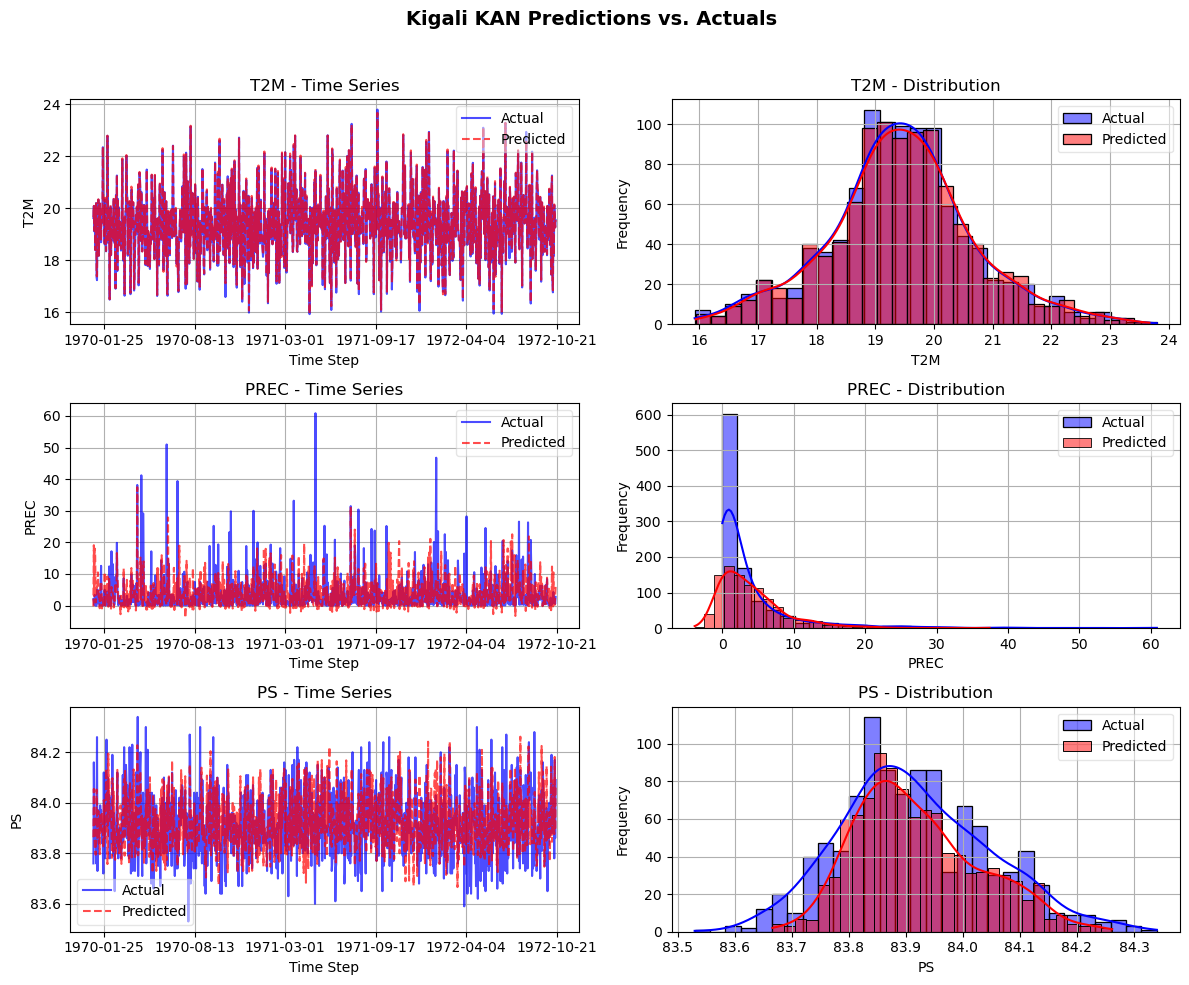

In [301]:
# models_Abj

kan_prediction_plots(dict_m, cities,scalers).to_csv("kan_metrics.csv")

In [155]:
# dict_dates_Kgl['T2M'][-1]

### Robustness